# Data Dictionary

|Attribute|Description
----------|-----------
InvoiceNo| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode| Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description| Product (item) name. Nominal.
Quantity| The quantities of each product (item) per transaction. Numeric.
InvoiceDate| Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice| Unit price. Numeric, Product price per unit in sterling.
CustomerID| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country| Country name. Nominal, the name of the country where each customer resides.

# 0.0 Imports

In [1]:
import pandas as pd
import inflection
from src import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as mt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.manifold as man
#import umap as um
import sweetviz
import umap.umap_ as um
from sklearn.decomposition import PCA


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:
#plt.style.use('ggplot')
sns.set_style('darkgrid')

# 0.1 Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  Unnamed: 8  
0   29-Nov-16       2.55     17850.0  United Kingdom         NaN  
1   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
2   29-Nov-16       2.75     17850.0  United Kingdom         NaN  
3   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
4   29-Nov-16       3.39     17850.0  United Kingdom         NaN

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 1.0. Data Description

In [5]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [6]:
df_description.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1. Renaming Columns

In [7]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [8]:
df_description['description'] = df_description['description'].str.lower()

In [9]:
df_description.sort_values(['invoice_date', 'description'])

invoice_no stock_code                       description  quantity  \
143414     548701      23007            spaceboy baby gift set         1   
143694     548711      22906   12 message cards with envelopes         2   
144000     548715      22906   12 message cards with envelopes         6   
143573     548708      84461      12 pink hen+chicks in basket         1   
144035     548715      21457  2 picture book eggs easter ducks         6   
...           ...        ...                               ...       ...   
335644     566290      84836       zinc metal heart decoration         2   
335748     566291      84836       zinc metal heart decoration         3   
335588     566290      23153  zinc sweetheart wire letter rack         2   
334150     566233      23145    zinc t-light holder star large        12   
334151     566233      23144   zinc t-light holder stars small        12   

       invoice_date  unit_price  customer_id         country  
143414     1-Apr-17       16.95      17629.0  United Kingdom  
143694     1-Apr-17        1.65      18116.0  United Kingdom  
144000     1-Apr-17        1.65      17758.0  United Kingdom  
143573     1-Apr-17        2.55      13269.0  United Kingdom  
144035     1-Apr-17        1.25      17758.0  United Kingdom  
...             ...         ...          ...             ...  
335644     9-Sep-17        1.25      14456.0  United Kingdom  
335748     9-Sep-17        1.25      12965.0  United Kingdom  
335588     9-Sep-17        3.75      14456.0  United Kingdom  
334150     9-Sep-17        0.95      12635.0         Germany  
334151     9-Sep-17        0.83      12635.0         Germany  

[541909 rows x 8 columns]

## 1.2. Data Dimension

In [10]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [11]:
gu.sum_table(df_description)

Name   dtypes  Uniques  Missing  Missing %
0    invoice_no   object    25900        0       0.00
1    stock_code   object     4070        0       0.00
2   description   object     4206     1454       0.27
3      quantity    int64      722        0       0.00
4  invoice_date   object      305        0       0.00
5    unit_price  float64     1630        0       0.00
6   customer_id  float64     4372   135080      24.93
7       country   object       38        0       0.00

## 1.4.  Handling Missing Values

Checking if there are invoice numbers of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [12]:
df_missing = df_description.query('customer_id.isnull()')
df_no_missing = df_description.query('~customer_id.isnull()')

In [13]:
inv_no_missing_customers = df_missing.invoice_no.unique()
stock_code_missing_customers = df_no_missing.stock_code.unique()

In [14]:

df_description.loc[df_description.invoice_date.isin(inv_no_missing_customers)]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

I tried to find invoice numbers of instances with missing customer id in other parts of the dataset to fill in missing values, but none were found.

In [15]:
missing_invoice_no = df_missing[['invoice_no']].drop_duplicates()
missing_invoice_no['customer_id'] = np.arange(19000, 19000+len(missing_invoice_no))

In [16]:
df_description = df_description.merge(missing_invoice_no, on='invoice_no', how='left')

In [17]:
df_description['customer_id'] = df_description['customer_id_x'].combine_first(df_description['customer_id_y'])
df_clean = df_description.drop(columns=['customer_id_x', 'customer_id_y'])

**Negative Quantity That are not cancellations**

In [18]:
df_clean.query("quantity <= 0 & invoice_no.str.isdigit()").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336 entries, 2406 to 538919
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    1336 non-null   object 
 1   stock_code    1336 non-null   object 
 2   description   474 non-null    object 
 3   quantity      1336 non-null   int64  
 4   invoice_date  1336 non-null   object 
 5   unit_price    1336 non-null   float64
 6   country       1336 non-null   object 
 7   customer_id   1336 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 93.9+ KB


## 1.5. Fixing Data Types

In [19]:
df_clean.invoice_date = pd.to_datetime(df_clean.invoice_date)
df_clean.customer_id = df_clean.customer_id.astype(int)

In [20]:
df_clean.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

  invoice_date  unit_price         country  customer_id  
0   2016-11-29        2.55  United Kingdom        17850  
1   2016-11-29        3.39  United Kingdom        17850  
2   2016-11-29        2.75  United Kingdom        17850  
3   2016-11-29        3.39  United Kingdom        17850  
4   2016-11-29        3.39  United Kingdom        17850

In [21]:
df_clean.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.6. Descriptive Statistics

### 1.6.1 Numerical Attributes

In [22]:
num_att = df_clean.select_dtypes(include=['float64', 'int64'])
cat_att = df_clean.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [23]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

Attributes       min      max      range      mean  median           var  \
0    quantity -80995.00  80995.0  161990.00  9.552250    3.00  47559.391409   
1  unit_price -11062.06  38970.0   50032.06  4.611114    2.08   9362.469164   

          std        skew       kurtosis  
0  218.081158   -0.264076  119769.160031  
1   96.759853  186.506972   59005.719097

In [24]:
df_clean.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997])[['quantity', 'unit_price']].T

count      mean         std       min    1%    5%   10%   20%  \
quantity    541909.0  9.552250  218.081158 -80995.00 -2.00  1.00  1.00  1.00   
unit_price  541909.0  4.611114   96.759853 -11062.06  0.19  0.42  0.63  0.85   

             50%    80%    90%    95%    99%   99.7%      max  
quantity    3.00  12.00  24.00  29.00  100.0  240.00  80995.0  
unit_price  2.08   4.95   7.95   9.95   18.0   39.95  38970.0

In [25]:
df_clean.sort_values('quantity').head()

invoice_no stock_code                          description  quantity  \
540422    C581484      23843          paper craft , little birdie    -80995   
61624     C541433      23166       medium ceramic top storage jar    -74215   
225529     556690      23005         printing smudges/thrown away     -9600   
225530     556691      23005         printing smudges/thrown away     -9600   
4287      C536757      84347  rotating silver angels t-light hldr     -9360   

       invoice_date  unit_price         country  customer_id  
540422   2017-12-07        2.08  United Kingdom        16446  
61624    2017-01-16        1.04  United Kingdom        12346  
225529   2017-06-12        0.00  United Kingdom        20914  
225530   2017-06-12        0.00  United Kingdom        20915  
4287     2016-11-30        0.03  United Kingdom        15838

There are some weird values in this dataset. We know that C stands for cancellation in the invoice code, so we expect to see a negative quantity in these instances. But we can observe some samples that aren't cancellations with a negative quantity. We will give a better look at this in the filter variables section.

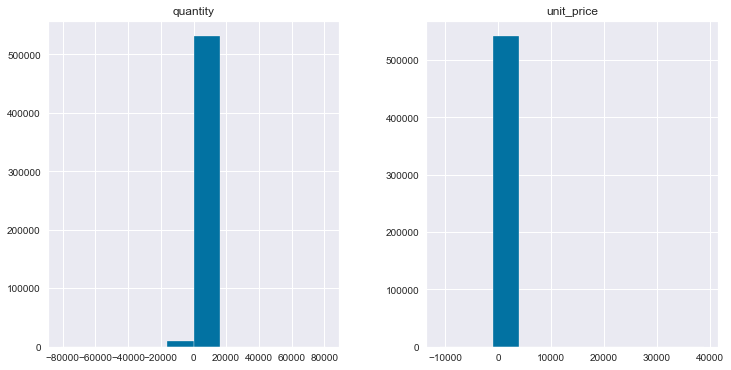

In [26]:
df_clean.drop(columns=['invoice_date', 'customer_id']).hist(figsize=(12, 6));

### <font color='red'> 1.6.2  Further Analysis needed </font>

Quantity with negative values -> What to do with cancellations.

Unit price < 0 -> error? remove these values?


### 1.6.1 Categorical Attributes

**Invoice Number with at least one string**

In [27]:
# df_description.inoice_no.astype(int)
letter_invoices = df_clean.loc[df_description.invoice_no.str.contains('C')]

print('Total Number of Cancelation invoices:', len(letter_invoices))
print('Total Number of Negative quantites:', len(letter_invoices.query('quantity < 0')))

Total Number of Cancelation invoices: 9288
Total Number of Negative quantites: 9288


**Stock codes with at least one string**

In [28]:
df_clean.loc[~df_clean.stock_code.str.isdigit()].head()

invoice_no stock_code                          description  quantity  \
0      536365     85123A   white hanging heart t-light holder         6   
2      536365     84406B       cream cupid hearts coat hanger         8   
3      536365     84029G  knitted union flag hot water bottle         6   
4      536365     84029E       red woolly hottie white heart.         6   
45     536370       POST                              postage         3   

   invoice_date  unit_price         country  customer_id  
0    2016-11-29        2.55  United Kingdom        17850  
2    2016-11-29        2.75  United Kingdom        17850  
3    2016-11-29        3.39  United Kingdom        17850  
4    2016-11-29        3.39  United Kingdom        17850  
45   2016-11-29       18.00          France        12583

**Stock codes that are only strings**

In [29]:
df_clean.loc[df_clean.stock_code.str.isalpha()].stock_code.value_counts()
# Remove stovk_code in [POST, M, D, DOT, CRUK, PADS, AMAZONFEE ,CRUK, DCGSSGIRL, DCGSSBOY, PADS, B, m]

POST         1256
DOT           710
M             571
D              77
S              63
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: stock_code, dtype: int64

In [30]:
df_clean.groupby('country').nunique()[['customer_id']].reset_index().sort_values('customer_id', ascending=False)

country  customer_id
36        United Kingdom         7587
14               Germany           95
13                France           90
10                  EIRE           44
31                 Spain           31
3                Belgium           25
33           Switzerland           24
27              Portugal           20
19                 Italy           15
16             Hong Kong           15
12               Finland           12
1                Austria           11
25                Norway           10
24           Netherlands            9
0              Australia            9
37           Unspecified            9
9                Denmark            9
6        Channel Islands            9
7                 Cyprus            8
32                Sweden            8
20                 Japan            8
18                Israel            7
26                Poland            6
5                 Canada            4
34                   USA            4
2                Bahrain            4
15                Greece            4
23                 Malta            2
35  United Arab Emirates            2
8         Czech Republic            1
22             Lithuania            1
11    European Community            1
21               Lebanon            1
28                   RSA            1
29          Saudi Arabia            1
30             Singapore            1
17               Iceland            1
4                 Brazil            1

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 2.0. Variables Filtering

In [31]:
df_filter = df_clean.copy()
columns = ['invoice_no', 'quantity', 'invoice_date', 'unit_price', 'customer_id']

In [32]:
df_filter.query("(quantity <= 0 & invoice_no.str.isdigit())").sort_values('quantity').head()

invoice_no stock_code                   description  quantity  \
225530     556691      23005  printing smudges/thrown away     -9600   
225529     556690      23005  printing smudges/thrown away     -9600   
225528     556687      23003  printing smudges/thrown away     -9058   
115818     546152     72140F                    throw away     -5368   
431381     573596     79323W        unsaleable, destroyed.     -4830   

       invoice_date  unit_price         country  customer_id  
225530   2017-06-12         0.0  United Kingdom        20915  
225529   2017-06-12         0.0  United Kingdom        20914  
225528   2017-06-12         0.0  United Kingdom        20913  
115818   2017-03-07         0.0  United Kingdom        19837  
431381   2017-10-29         0.0  United Kingdom        22229

By the description of those items, it seems like they are some mistakes or a problem with the product. We will remove this values from the data

In [33]:
df_filter = df_filter.query("~(quantity <= 0 & invoice_no.str.isdigit())")

## 2.1. Numerical

In [34]:
desc = df_filter[['customer_id', 'description', 'quantity', 'unit_price']].query('unit_price < 0.04').description.unique()#.sort_values('unit_price', ascending=False).head(10)
items_with_multiple_unit_prices = (df_filter.groupby('description').nunique()[['unit_price']] > 1).index

df_filter.loc[(df_filter['description'].isin(items_with_multiple_unit_prices)) & (df_filter['description'].isin(desc)) ].sort_values(['description', 'unit_price',]).head(10)

invoice_no stock_code                  description  quantity  \
279324     561284      22167   oval wall mirror diamante          1   
174137     551747      22167   oval wall mirror diamante         24   
60112      541421      22167   oval wall mirror diamante          2   
65218      541695      22167   oval wall mirror diamante          2   
66845      541827      22167   oval wall mirror diamante          1   
68670      541871      22167   oval wall mirror diamante          1   
73262      542344      22167   oval wall mirror diamante          1   
75108      542541      22167   oval wall mirror diamante          1   
76246      542622      22167   oval wall mirror diamante          1   
79928      543013      22167   oval wall mirror diamante          1   

       invoice_date  unit_price         country  customer_id  
279324   2017-07-24        0.00  United Kingdom        16818  
174137   2017-05-02        3.95  United Kingdom        14298  
60112    2017-01-15        8.29  United Kingdom        19414  
65218    2017-01-18        8.29  United Kingdom        19443  
66845    2017-01-19        8.29  United Kingdom        19451  
68670    2017-01-22        8.29  United Kingdom        19455  
73262    2017-01-25        8.29  United Kingdom        19477  
75108    2017-01-26        8.29  United Kingdom        19514  
76246    2017-01-29        8.29  United Kingdom        19552  
79928    2017-01-31        8.29  United Kingdom        19578

In [35]:
df_filter = df_filter.query('unit_price >= 0.04')

What to do if a customer has a negative spent overall. In this dataset the cancellation code doesn't match the transaction code.


idea for next cycle: compute the average unit price, or the mode, for each product (without the zero values) and fill the extremly low values with it.

## 2.2. Categorical

In [36]:
# removing stock_codes that are only letters
df_filter = df_filter.query("~stock_code.isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])")

# removing European Community and Unspecified
df_filter = df_filter.query("~country.isin(['European Community', 'Unspecified'])")

country_dict = {'EIRE': 'Ireland', 'RSA': 'South Africa', 'USA': 'United States', 'Channel Islands': 'United Kingdom'}

countries_to_modify = ['USA', 'Channel Islands', 'RSA', 'EIRE']

df_filter.country = df_filter.country.apply(lambda x: country_dict[x] if x in countries_to_modify else x)

In [37]:
# description
print(f'Removed data: {1 - (df_filter.shape[0]/df_clean.shape[0]):.3%}')
print(f'Number of Elements Removed: {df_clean.shape[0] - df_filter.shape[0]}')

Removed data: 1.064%
Number of Elements Removed: 5766


In [38]:
df_filter.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

In [39]:
print('Number of rows Cancelation:', df_filter.query("quantity < 0 or invoice_no.str.contains('C')").shape[0])
print('Number of rows Transaction:', df_filter.query('quantity > 0').shape[0])

Number of rows Cancelation: 8729
Number of rows Transaction: 527414


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 3.0. Feature Engineering

In [40]:
# Moving Average
# Quantidade de compras por mês, antes do dia 15 e depois do dia 15
# Average Financial
# Basket SIze Price

In [73]:
df_feature = df_filter.copy()
df_feature_cancelation = df_filter.query("quantity < 0 or invoice_no.str.contains('C')").copy()
df_feature_transaction = df_filter.query('quantity > 0').copy()

In [74]:
countries_lat_long = pd.read_csv('../data/external/countries.csv')
countries_lat_long.head()

country   latitude  longitude                  name
0      AD  42.546245   1.601554               Andorra
1      AE  23.424076  53.847818  United Arab Emirates
2      AF  33.939110  67.709953           Afghanistan
3      AG  17.060816 -61.796428   Antigua and Barbuda
4      AI  18.220554 -63.068615              Anguilla

In [75]:
countries_lat_long.rename(columns={'name': 'country', 'country': 'code'}, inplace=True)

**Recency, Frequency and Monetary**

In [76]:
df_feature['gross_revenue'] = df_feature.quantity * df_feature.unit_price

# Recency
diff = df_filter.invoice_date.max() - df_feature_transaction.groupby('customer_id').max()['invoice_date']
recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

recency['recency'] = recency['recency'].dt.days
df_feature = df_feature.merge((recency), how='left', on='customer_id')


# Frequency
min_date = df_feature.invoice_date.min()
max_date = df_feature.invoice_date.max()
aux = aux = df_feature_transaction.groupby('customer_id').agg( max_ = ('invoice_date', 'max'), 
                                       min_ = ('invoice_date', 'min'),
                                       days_ = ('invoice_date', lambda x: (max_date - min_date).days + 1),
                                       buy_ = ('invoice_no', 'nunique'),
                                      ).reset_index()

aux['frequency'] = aux.buy_/aux.days_
aux['frequency'] = aux.buy_/aux.days_

df_feature = df_feature.merge(aux[['customer_id', 'frequency']], on='customer_id', how='left')

# Monetary
monetary = df_feature.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'monetary'})
df_feature = df_feature.merge((monetary), how='left', on='customer_id')

In [77]:
#min_date = df_feature.invoice_date.min()
#max_date = df_feature.invoice_date.max()
#aux = aux = df_feature_transaction.groupby('customer_id').agg( max_ = ('invoice_date', 'max'), 
#                                       min_ = ('invoice_date', 'min'),
#                                       days_ = ('invoice_date', lambda x: (max_date - min_date).days + 1),
#                                       buy_ = ('invoice_no', 'nunique'),
#                                      ).reset_index()
#
#aux['frequency'] = aux.buy_/aux.days_
#
#aux['frequency'] = aux.buy_/aux.days_
#aux

**Number of transactions, Variety, Average Ticket and Average Basket Size**

In [78]:
# Transactions
transactions = df_feature_transaction.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'transactions'})
df_feature = df_feature.merge((transactions), how='left', on='customer_id')

# Average Ticket
avg_ticket = df_feature.groupby(['customer_id', 'invoice_no']).sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'avg_ticket'}).groupby('customer_id').mean(numeric_only=True).reset_index()
df_feature = df_feature.merge((avg_ticket), how='left', on='customer_id')

# Product Variety
product_variety = df_feature_transaction.groupby('customer_id').nunique()[['description']].reset_index().rename(columns={'description': 'product_variety'})
df_feature = df_feature.merge((product_variety), how='left', on='customer_id')

# Average Basket Size 
avg_basket = df_feature[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).sum()\
                                                                                                                .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                .reset_index().rename(columns={'quantity': 'avg_basket'})
df_feature = df_feature.merge((avg_basket), how='left', on='customer_id')


# Average Basket Variety Size
avg_basket_var = df_feature[['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id', 'invoice_no']).nunique()\
                                                                                                                .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                .reset_index().rename(columns={'stock_code': 'avg_basket_variety'})
df_feature = df_feature.merge(avg_basket_var, how='left', on='customer_id')

**Average Recency, Total Cancelltions, Quantity**

In [79]:
df_aux = df_feature_transaction[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])

df_aux['previous_date'] = df_aux.shift(periods=1).sort_values(['customer_id', 'invoice_date'])['invoice_date']
df_aux['previous_customer_id'] = df_aux.shift(periods=1).sort_values(['customer_id', 'invoice_date'])['customer_id']

df_aux['days']  = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if float(x['customer_id']) == x['previous_customer_id'] else np.nan, axis=1)
df_aux = df_aux.dropna()

df_recency_avg = df_aux.groupby('customer_id').mean(numeric_only=True).reset_index()[['customer_id', 'days']].rename(columns={'days': 'avg_recency'})
df_feature = df_feature.merge(df_recency_avg, on='customer_id', how='left')


cancelations = df_feature_cancelation[['customer_id', 'quantity']].groupby('customer_id').apply(lambda c: c.abs().sum())[['quantity']].reset_index().rename(columns={'quantity': 'number_of_cancelations'})
df_feature = df_feature.merge(cancelations, how='left', on='customer_id')


# Total Quantity
quantity = df_feature.groupby('customer_id').sum(numeric_only=True).quantity.reset_index().rename(columns={'quantity': 'total_quantity'})
df_feature = df_feature.merge(quantity, how='left', on='customer_id')

df_feature.isnull().sum()

invoice_no                     0
stock_code                     0
description                    0
quantity                       0
invoice_date                   0
unit_price                     0
country                        0
customer_id                    0
gross_revenue                  0
recency                      275
frequency                    275
monetary                       0
transactions                 275
avg_ticket                     0
product_variety              275
avg_basket                     0
avg_basket_variety             0
avg_recency               168440
number_of_cancelations    292998
total_quantity                 0
dtype: int64

Some customers only have cancellations, they need to be removed.

In [80]:
## Average unit price
#avg_uprice = df_feature.groupby('customer_id').mean(numeric_only=True)[['unit_price']].reset_index().rename(columns={'unit_price': 'avg_unit_price'})
#df_feature = df_feature.merge(avg_uprice, how='left', on='customer_id')

# Total Cancelation
#df_feature_cancelation['total_returned'] = -df_feature_cancelation.quantity * df_feature_cancelation.unit_price
#total_returned = df_feature_cancelation.groupby('customer_id').sum()[['total_returned']].reset_index()
#
#df_feature = df_feature.merge(total_returned, how='left', on='customer_id')
#


In [81]:
#df_feature_transaction.fillna(0, inplace=True)

In [82]:
columns = ['customer_id', 'country', 'recency', 'frequency', 'monetary', 'transactions', 'total_quantity', 'avg_ticket', 'product_variety', 'avg_basket', 'avg_basket_variety', 'number_of_cancelations']
df_customers = df_feature.drop_duplicates('customer_id').copy()[columns]
df_customers.head()

customer_id         country  recency  frequency  monetary  transactions  \
0         17850  United Kingdom    372.0   0.090909   5288.63          34.0   
9         13047  United Kingdom     56.0   0.024064   3089.10           9.0   
26        12583          France      2.0   0.040107   6629.34          15.0   
45        13748  United Kingdom     95.0   0.013369    948.25           5.0   
64        15100  United Kingdom    333.0   0.008021    635.10           3.0   

    total_quantity  avg_ticket  product_variety  avg_basket  \
0             1693  151.103714             21.0   48.371429   
9             1355  193.068750            105.0   84.687500   
26            4978  389.961176            116.0  292.823529   
45             439  189.650000             24.0   87.800000   
64              58  105.850000              1.0    9.666667   

    avg_basket_variety  number_of_cancelations  
0             8.742857                    40.0  
9            12.125000                    35.0  
26           13.823529                    50.0  
45            5.600000                     NaN  
64            1.000000                    22.0

In [83]:
df_customers.isnull().sum()

customer_id                  0
country                      0
recency                     91
frequency                   91
monetary                     0
transactions                91
total_quantity               0
avg_ticket                   0
product_variety             91
avg_basket                   0
avg_basket_variety           0
number_of_cancelations    4191
dtype: int64

In [84]:
df_customers['number_of_cancelations'] = df_customers['number_of_cancelations'].fillna(0)

**For this cycle I will remove customers that have a negative monetary value.**

In [85]:
df_customers_clean = df_customers.query('(monetary > 0.1)')
print('Items Removed:', df_customers.query('(monetary <= 0)').shape[0])

Items Removed: 101


In [86]:
df_customers_clean.isnull().sum()

customer_id               0
country                   0
recency                   0
frequency                 0
monetary                  0
transactions              0
total_quantity            0
avg_ticket                0
product_variety           0
avg_basket                0
avg_basket_variety        0
number_of_cancelations    0
dtype: int64

In [87]:
df_customers_clean = df_customers_clean.merge(countries_lat_long, on='country', how='left')

In [88]:
df_customers_clean.isnull().sum()

customer_id               0
country                   0
recency                   0
frequency                 0
monetary                  0
transactions              0
total_quantity            0
avg_ticket                0
product_variety           0
avg_basket                0
avg_basket_variety        0
number_of_cancelations    0
code                      0
latitude                  0
longitude                 0
dtype: int64

In [89]:
#removed = df_customers.query('(total_returned >= monetary)').shape[0]
#percent = removed/df_customers.shape[0]
# 
#print(f'Number of elements Removed: {removed}\nPercetual removed: {percent:.2%}')
#df_customers.query('~(total_returned >= monetary)')

In [90]:
df_customers_clean.sort_values('monetary')

customer_id         country  recency  frequency   monetary  \
969         19242  United Kingdom    357.0   0.002674       0.42   
1240        19391  United Kingdom    332.0   0.002674       0.65   
3963        21228  United Kingdom    147.0   0.002674       0.79   
4024        21307  United Kingdom    141.0   0.002674       0.84   
1496        19470  United Kingdom    318.0   0.002674       0.84   
...           ...             ...      ...        ...        ...   
1121        12415       Australia     24.0   0.053476  123638.18   
65          14911         Ireland      1.0   0.532086  133007.13   
423         17450  United Kingdom      8.0   0.122995  189735.53   
481         18102  United Kingdom      0.0   0.160428  259657.30   
992         14646     Netherlands      1.0   0.192513  278778.02   

      transactions  total_quantity   avg_ticket  product_variety   avg_basket  \
969            1.0               1     0.420000              1.0     1.000000   
1240           1.0               1     0.650000              1.0     1.000000   
3963           1.0               1     0.790000              1.0     1.000000   
4024           1.0               2     0.840000              2.0     2.000000   
1496           1.0               2     0.840000              1.0     2.000000   
...            ...             ...          ...              ...          ...   
1121          20.0           76946  5151.590833            450.0  3206.083333   
65           199.0           76931   547.354444           1815.0   316.588477   
423           46.0           69041  3872.153673            125.0  1409.000000   
481           60.0           64124  4327.621667            162.0  1068.733333   
992           72.0          196556  3818.876986            717.0  2692.547945   

      avg_basket_variety  number_of_cancelations code   latitude   longitude  
969             1.000000                     0.0   GB  55.378051   -3.435973  
1240            1.000000                     0.0   GB  55.378051   -3.435973  
3963            1.000000                     0.0   GB  55.378051   -3.435973  
4024            2.000000                     0.0   GB  55.378051   -3.435973  
1496            1.000000                     0.0   GB  55.378051   -3.435973  
...                  ...                     ...  ...        ...         ...  
1121           32.250000                   427.0   AU -25.274398  133.775136  
65             24.242798                  3332.0   IE  53.412910   -8.243890  
423             6.918367                   952.0   GB  55.378051   -3.435973  
481             7.183333                     0.0   GB  55.378051   -3.435973  
992            28.246575                   288.0   NL  52.132633    5.291266  

[5681 rows x 15 columns]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 4.0. Exploratory Data Analysis

In [91]:
df_eda = df_customers_clean.copy().drop(columns='code', axis=0)

## 4.1 Univariate Analysis

In [92]:
import warnings
warnings.filterwarnings('ignore')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



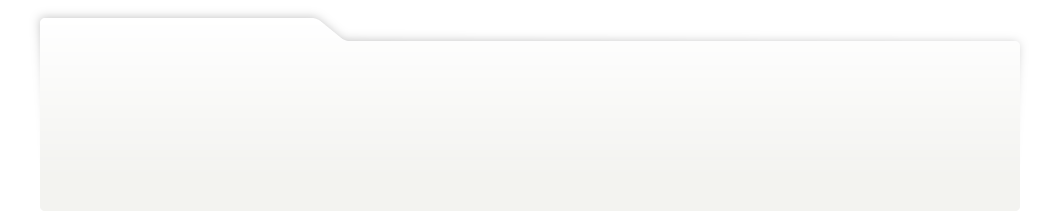
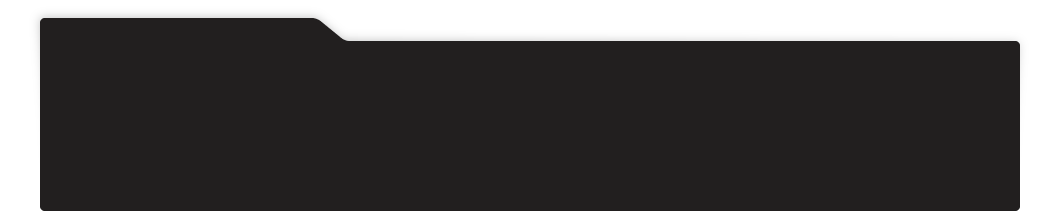
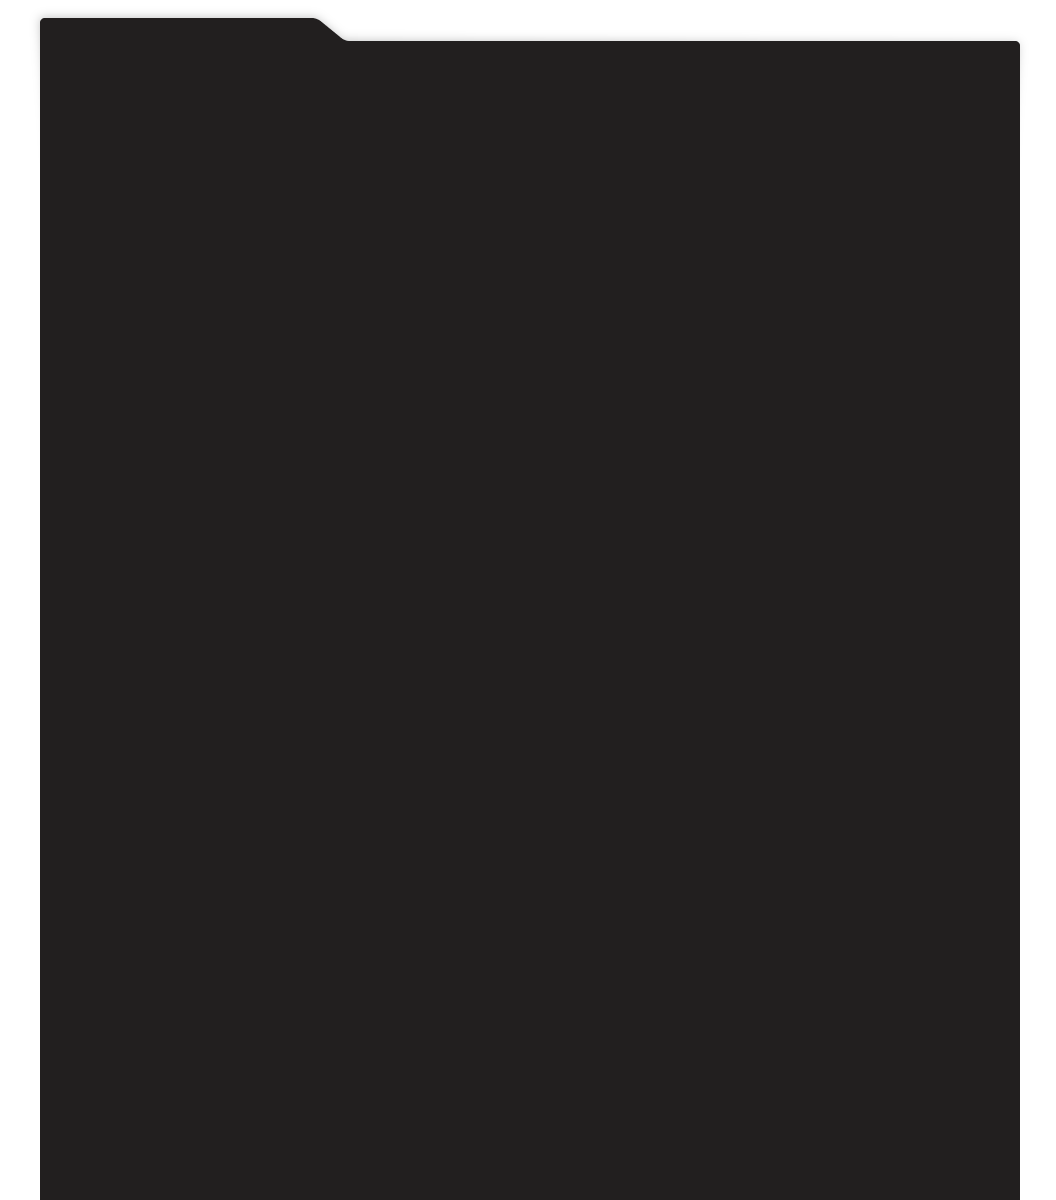
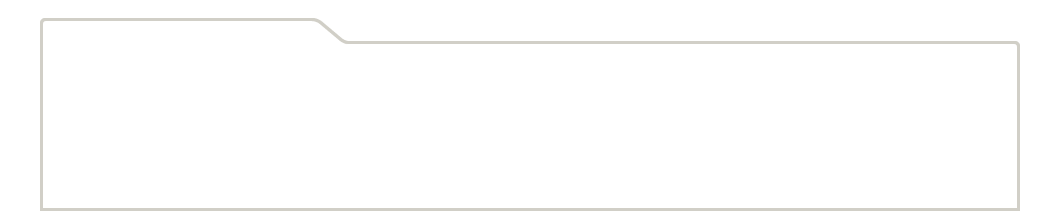
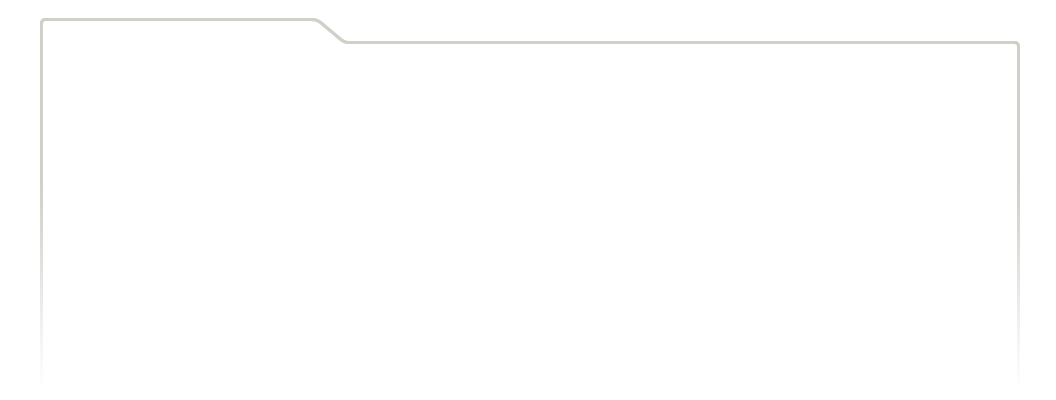
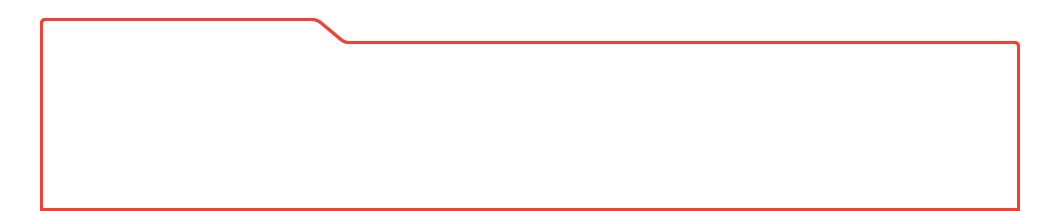
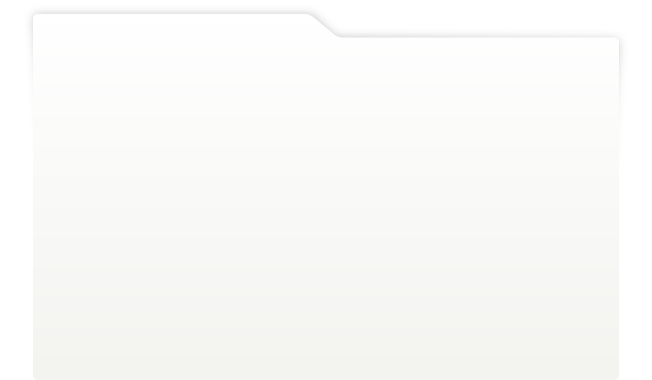
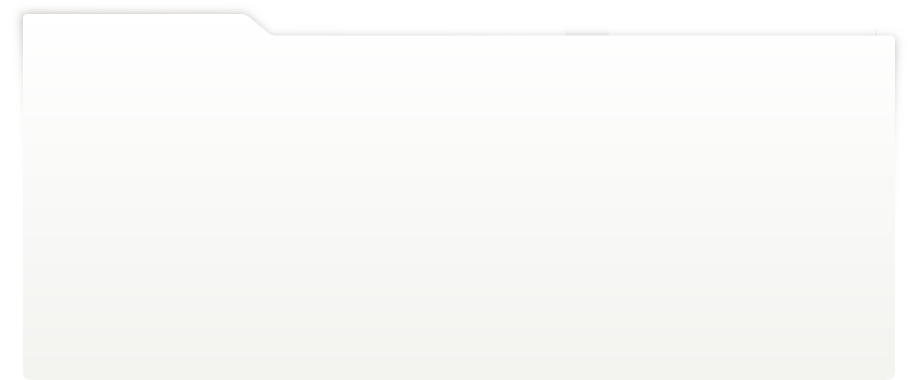
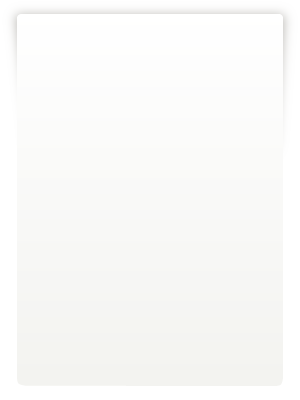
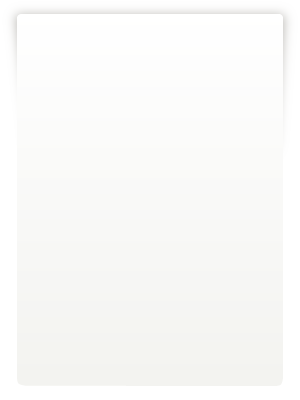
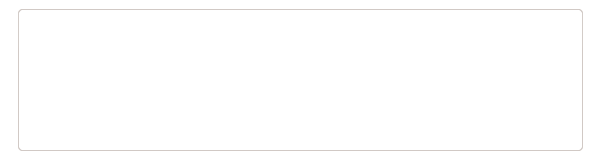
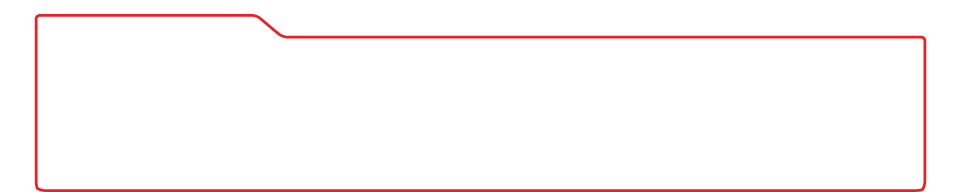
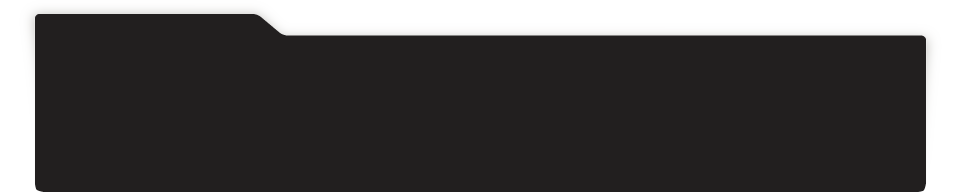
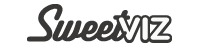
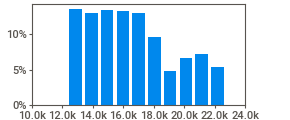
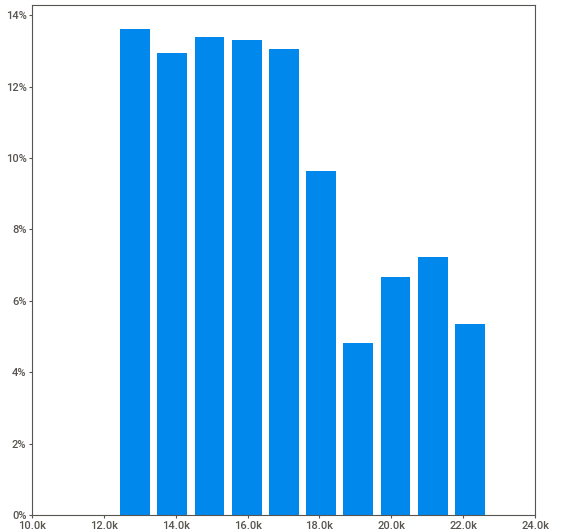
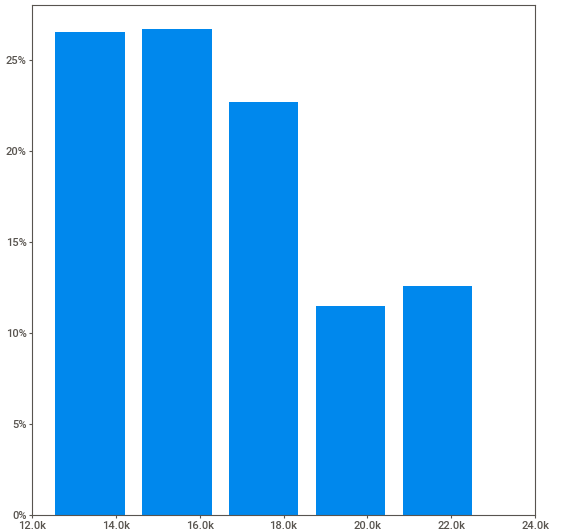
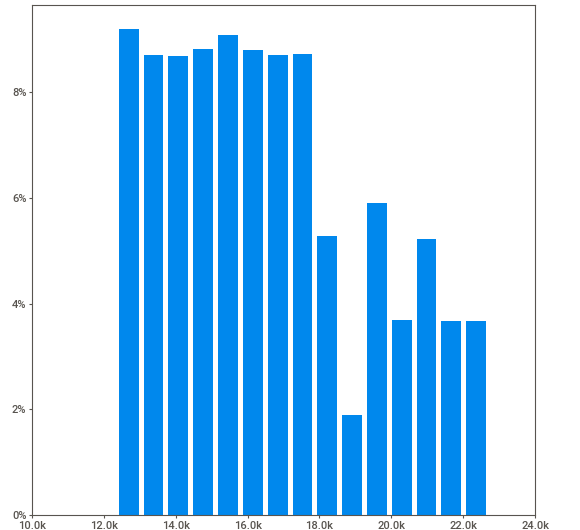
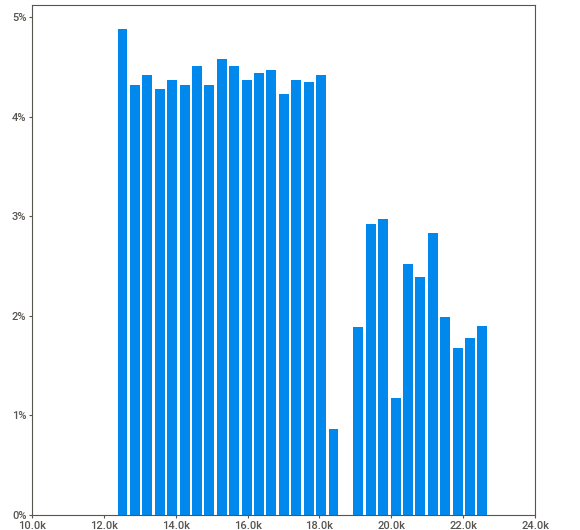
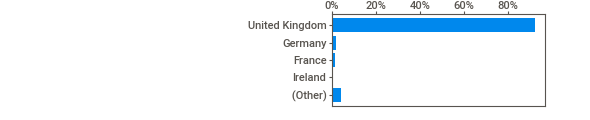
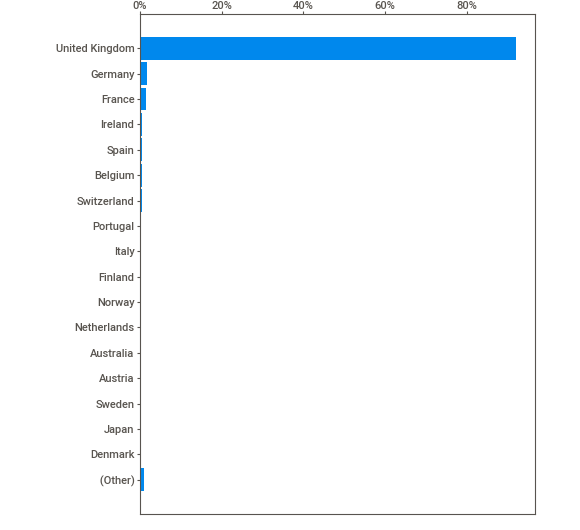
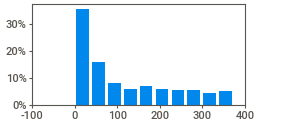
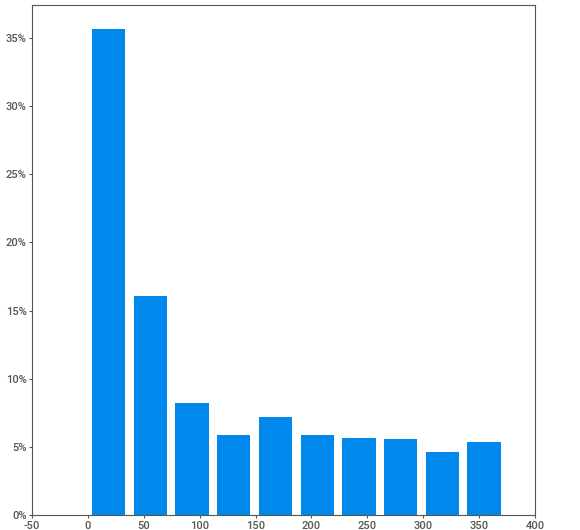
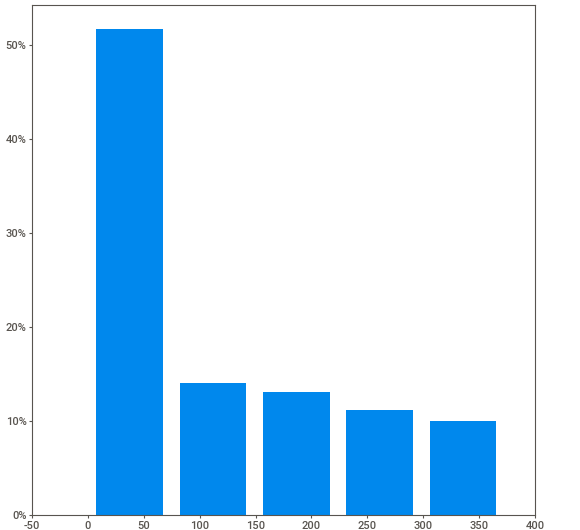
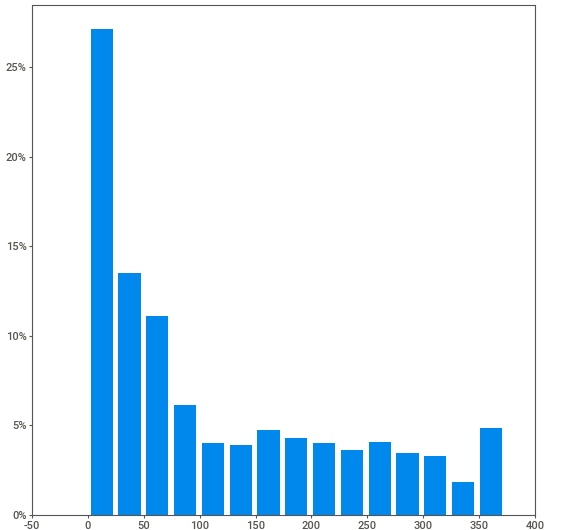
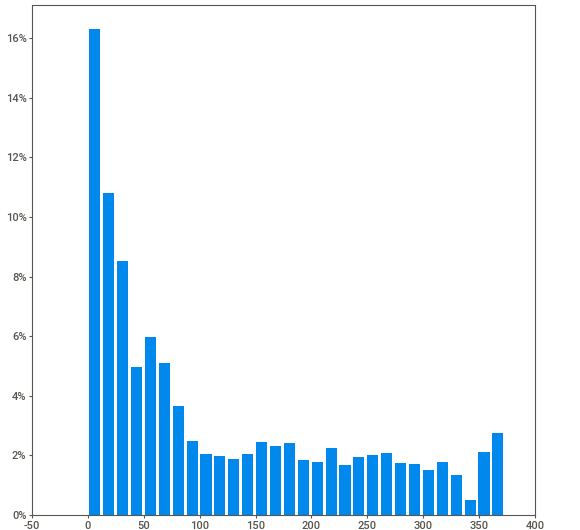
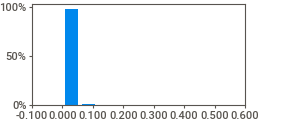
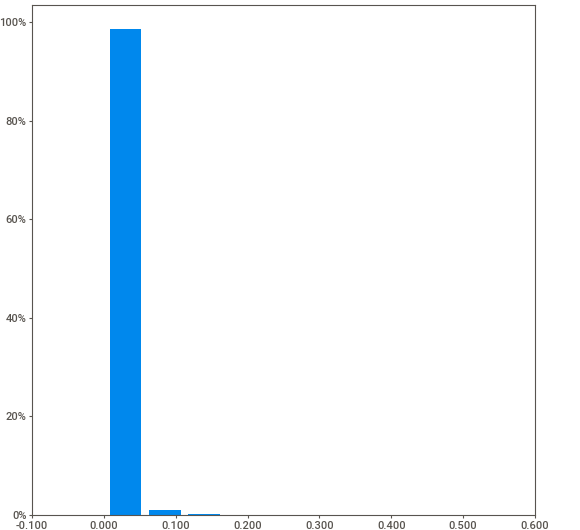
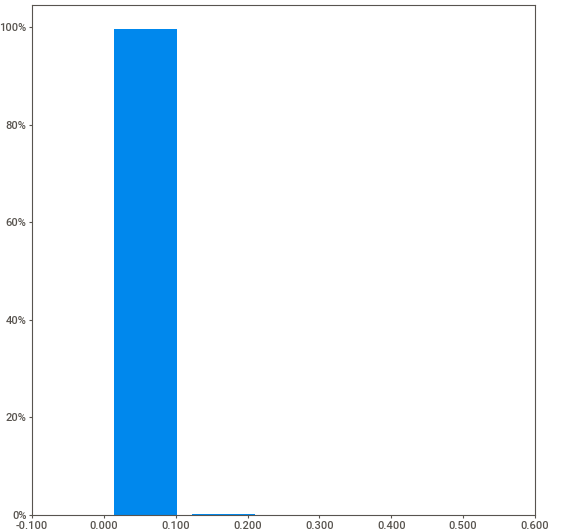
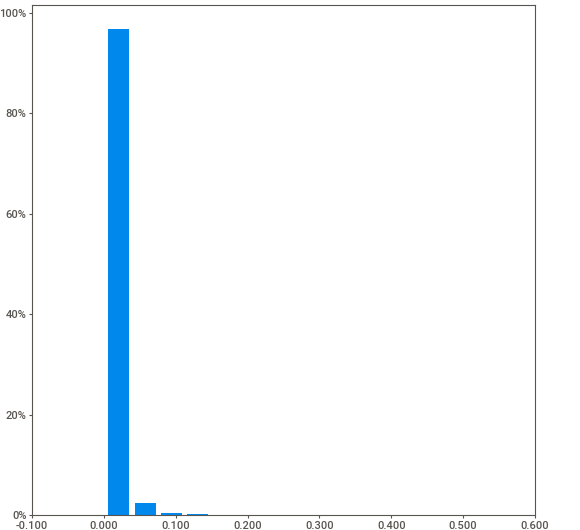
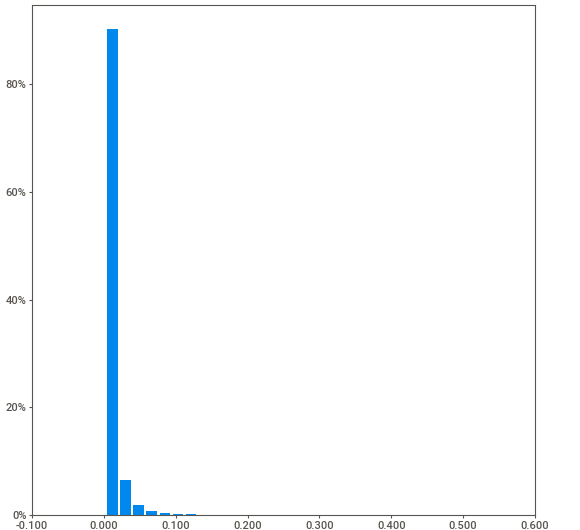
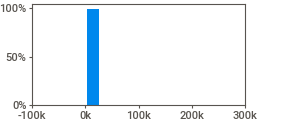
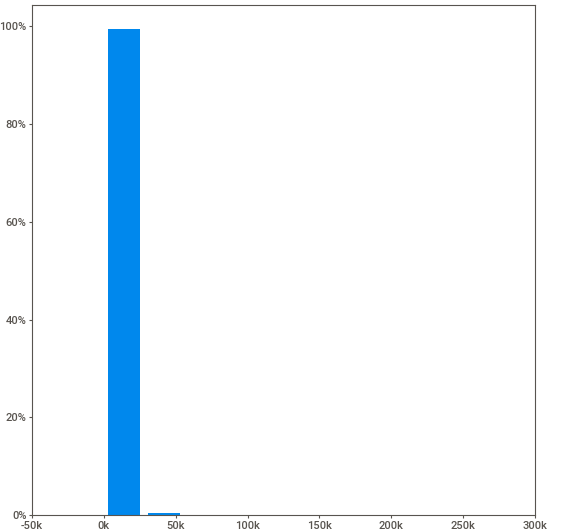
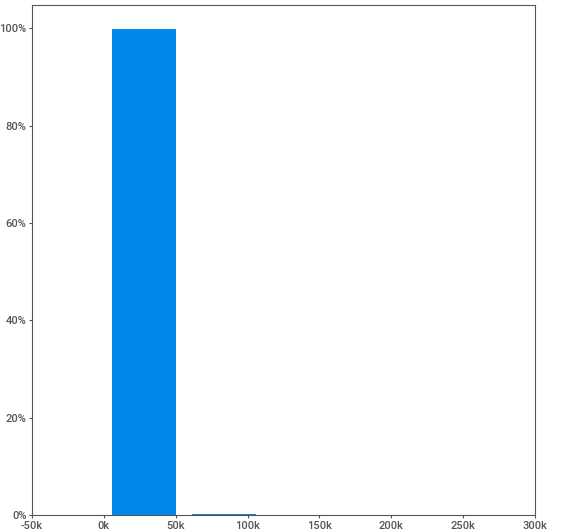
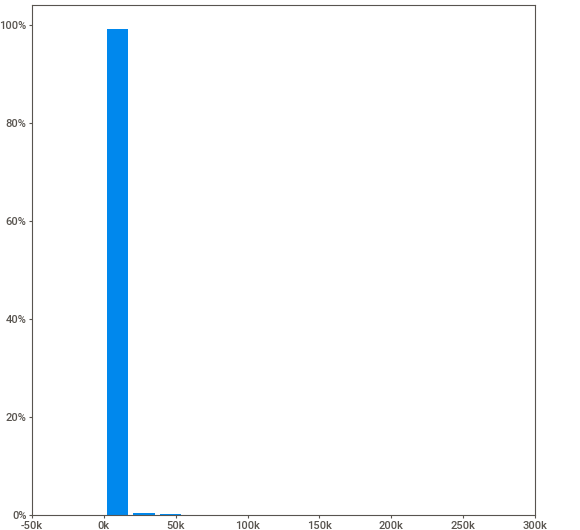
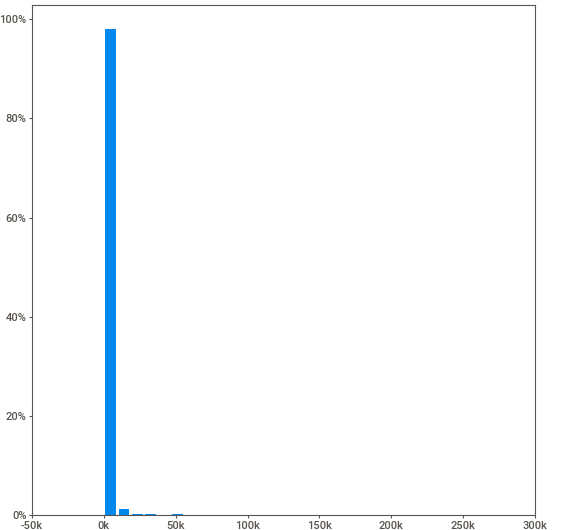
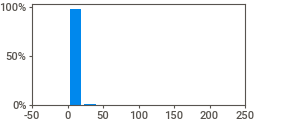
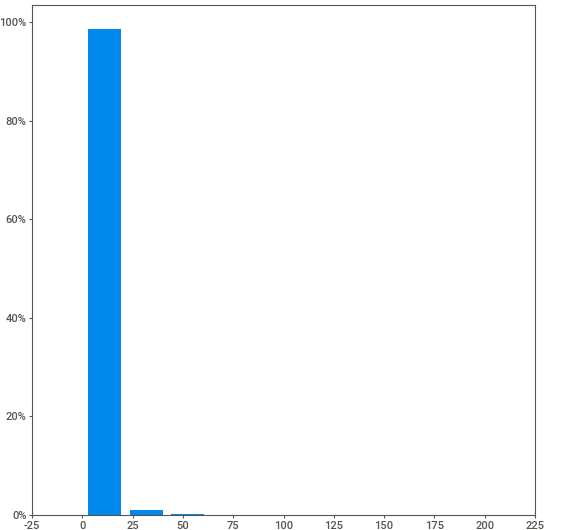
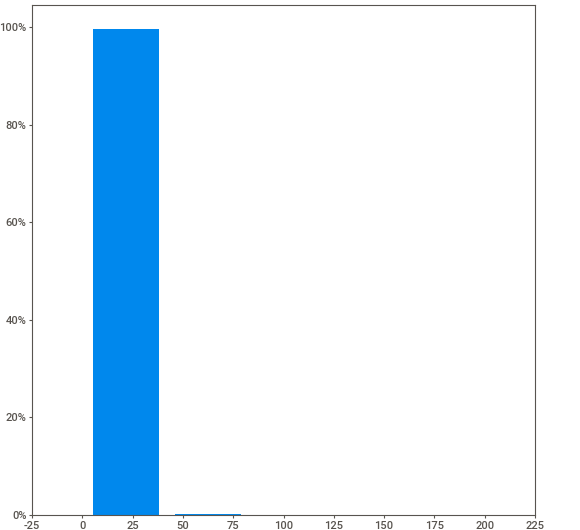
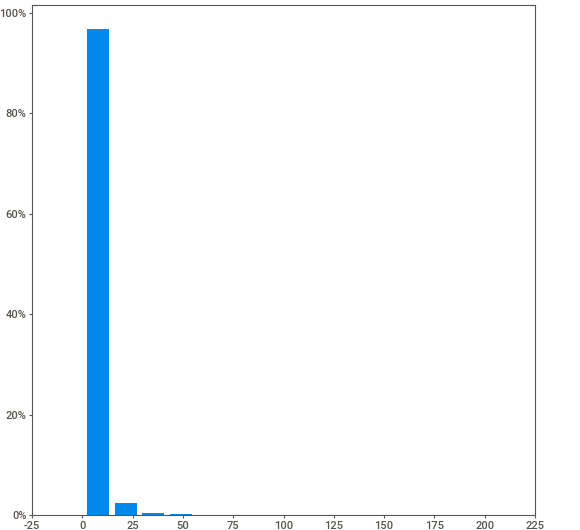
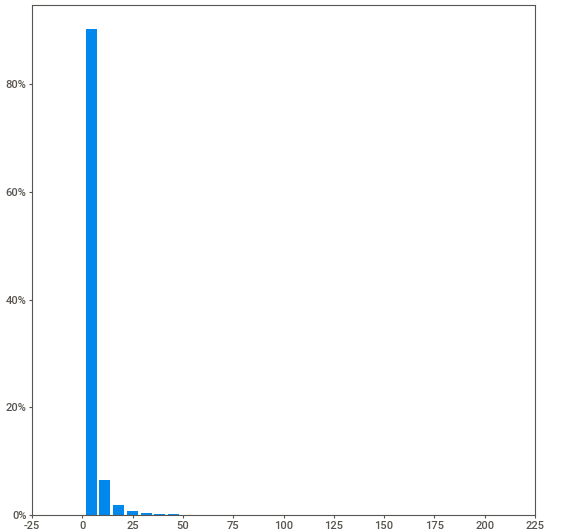
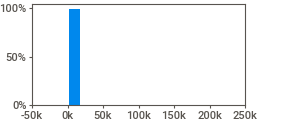
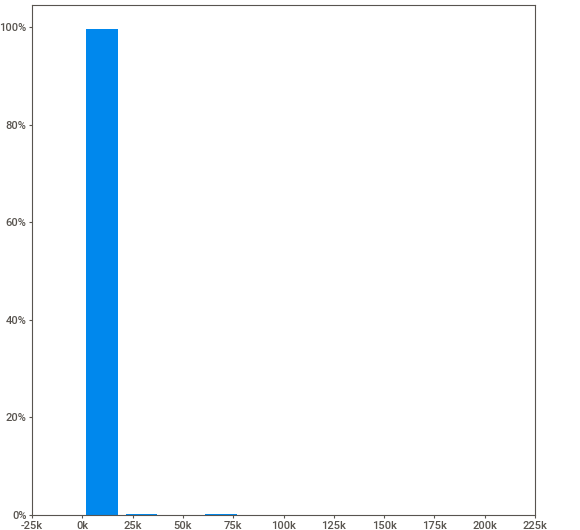
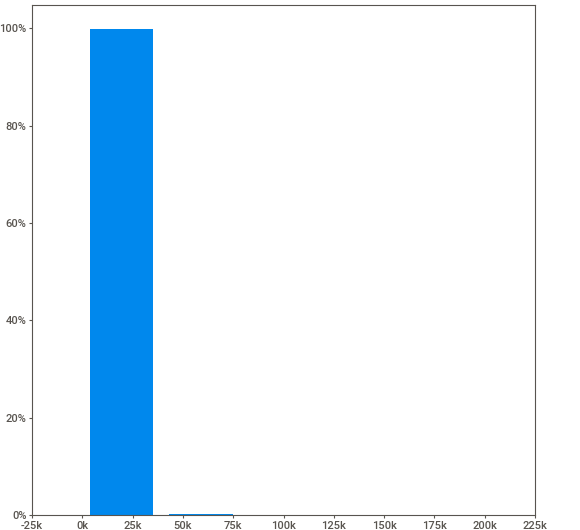
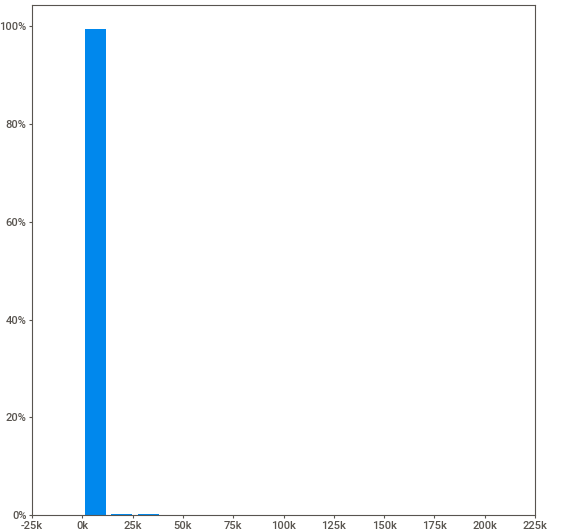
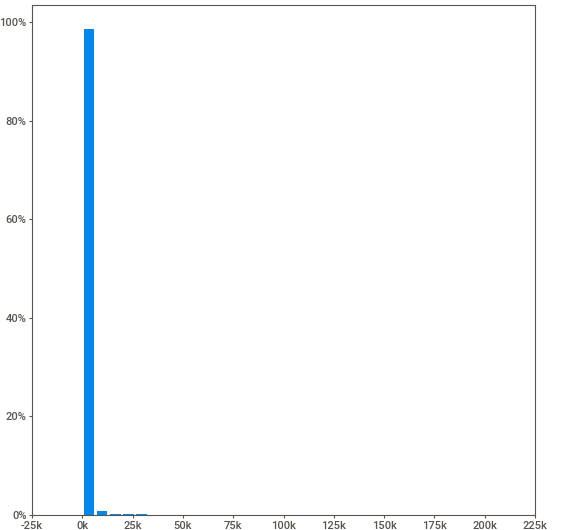
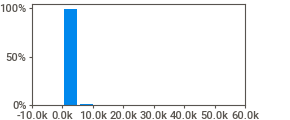
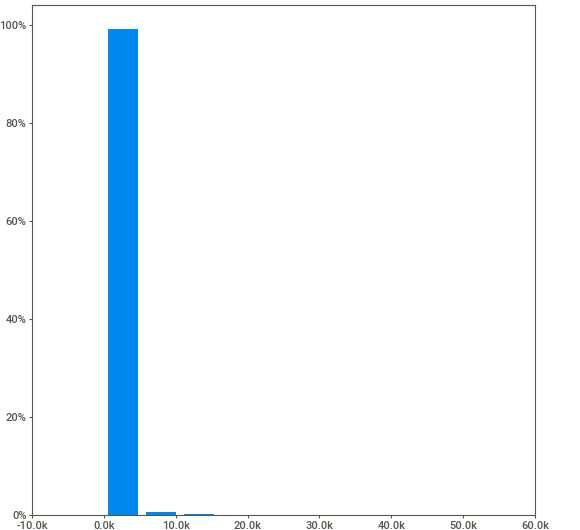
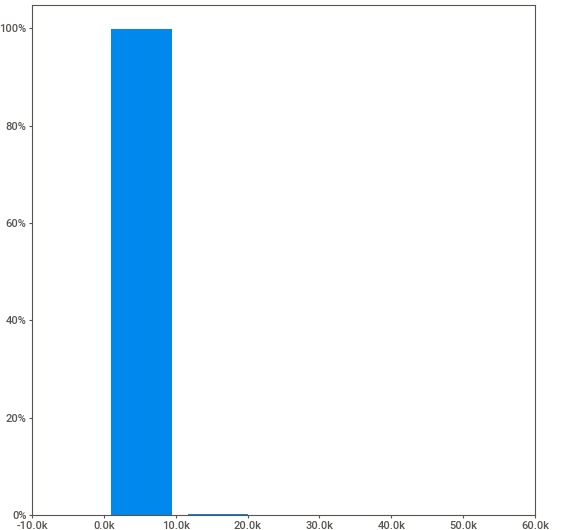
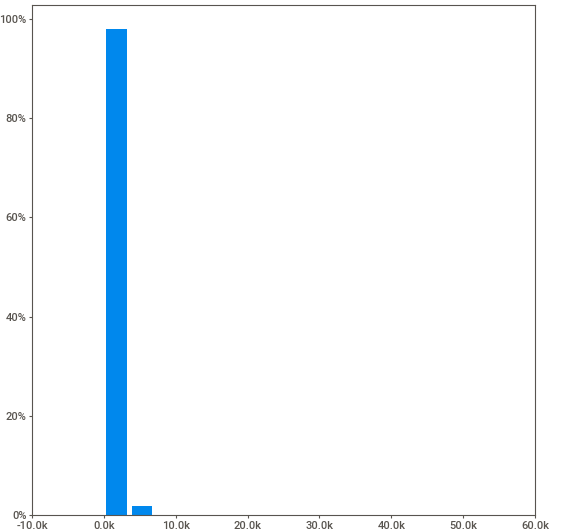
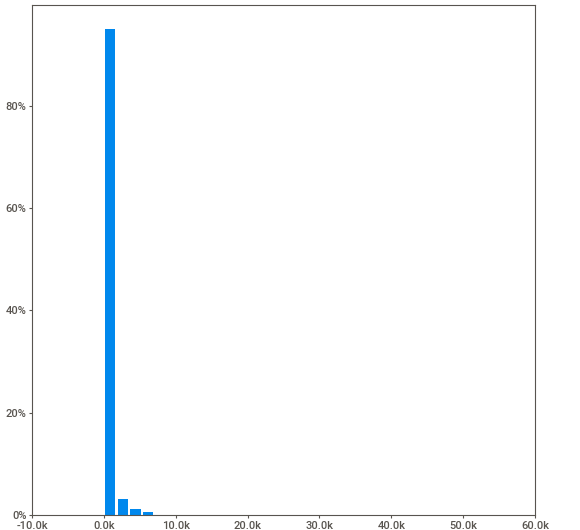
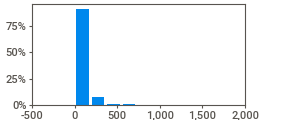
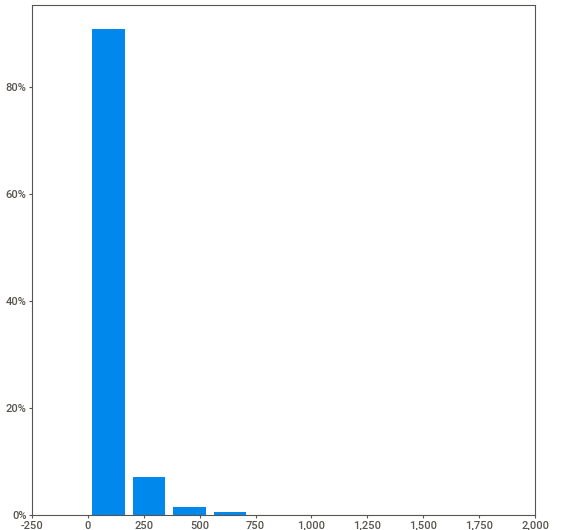
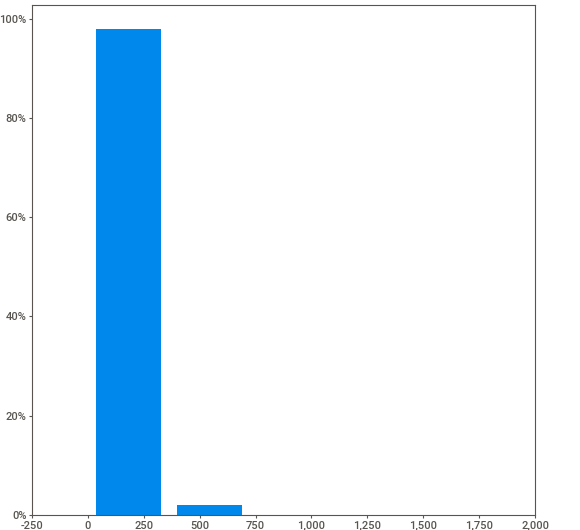
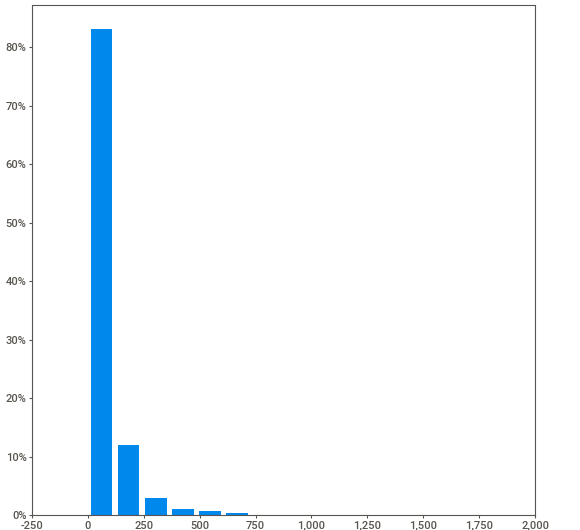
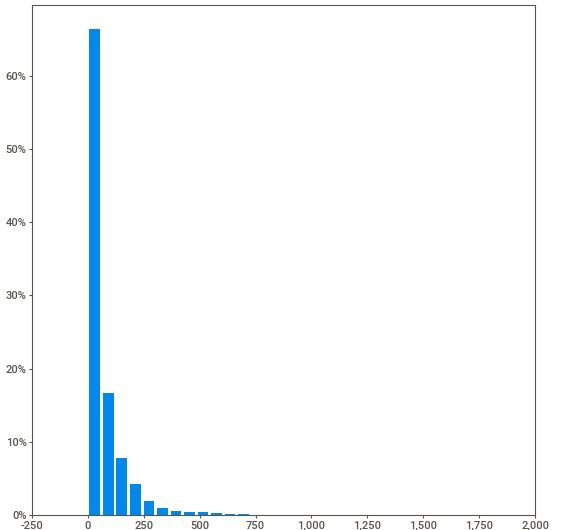
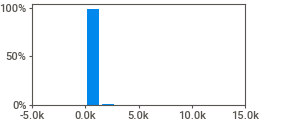
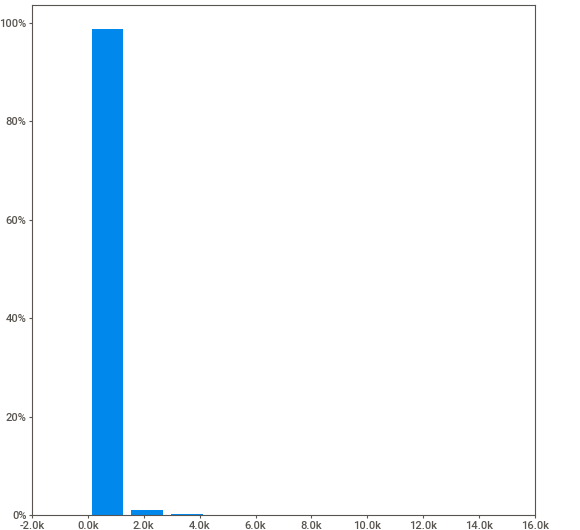
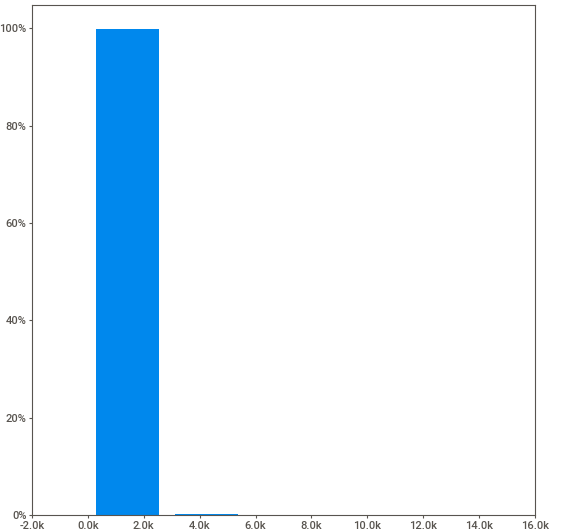
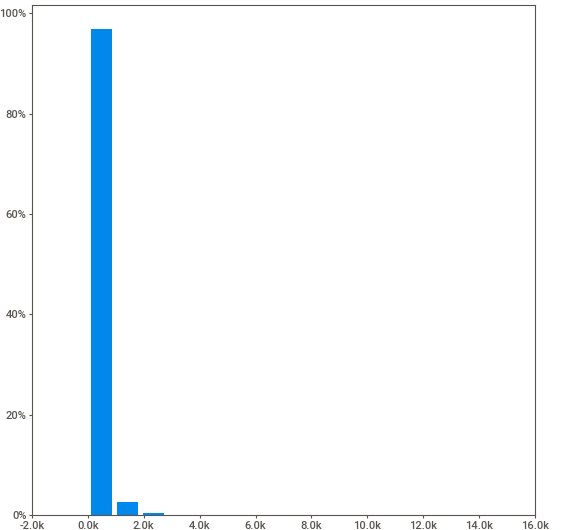
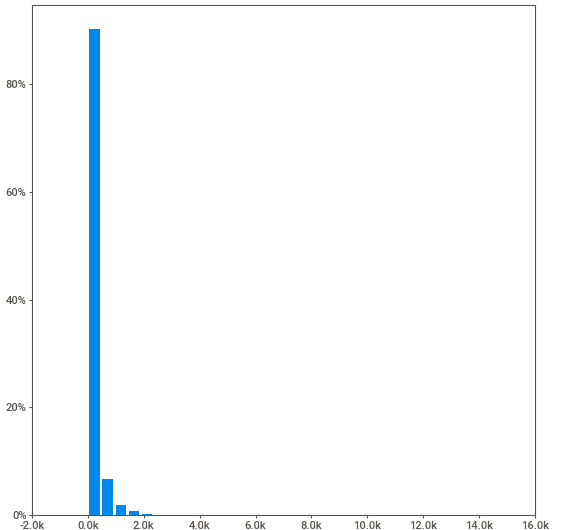
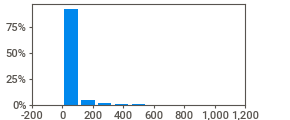
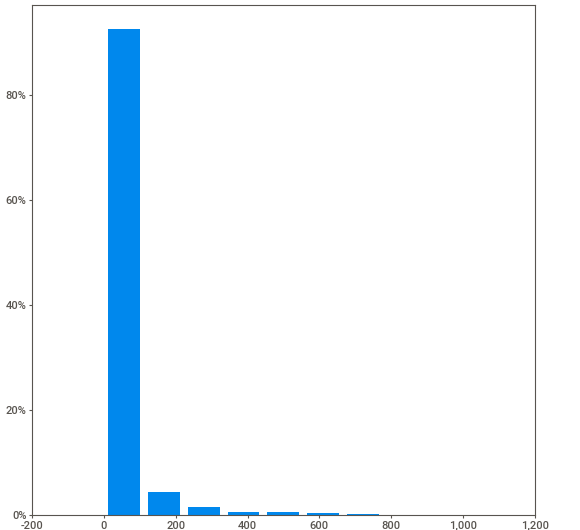
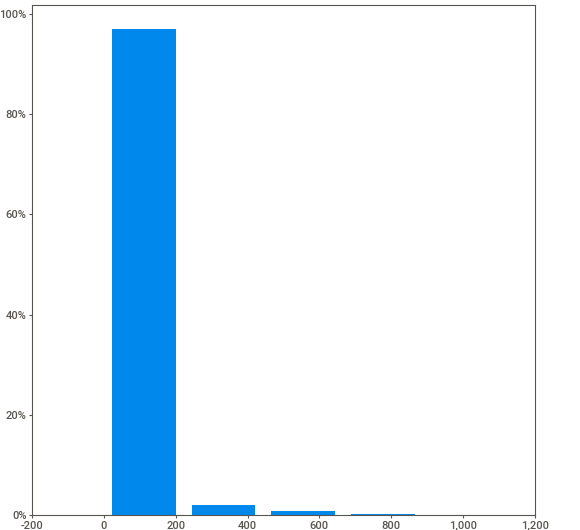
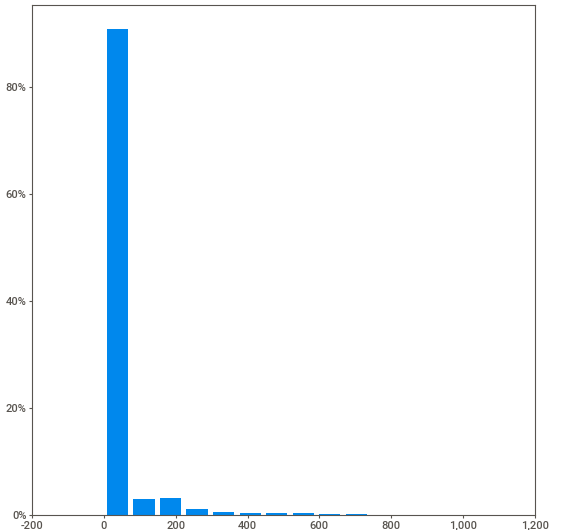
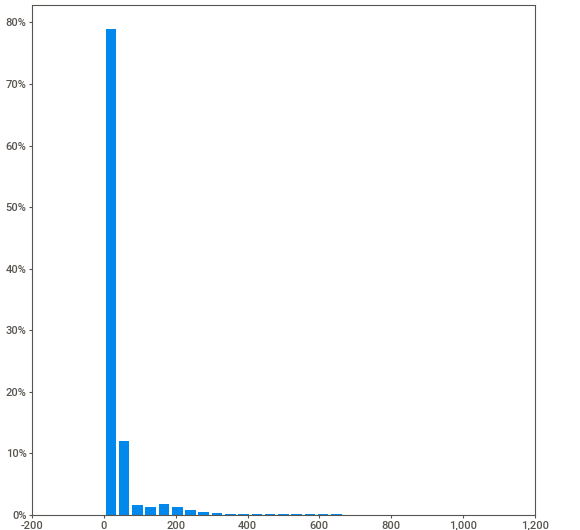
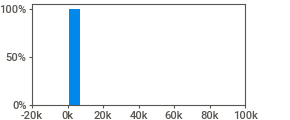
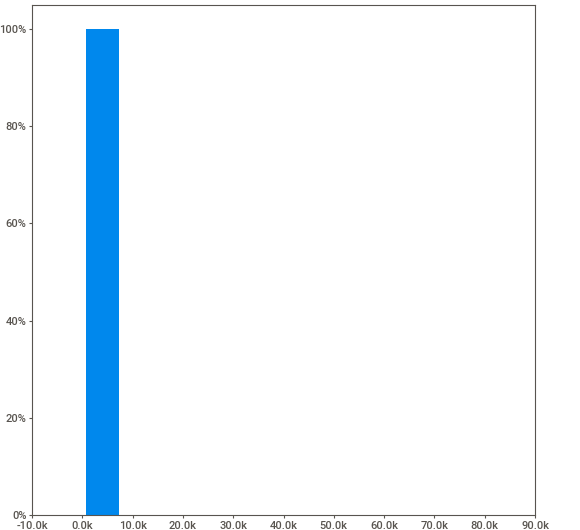
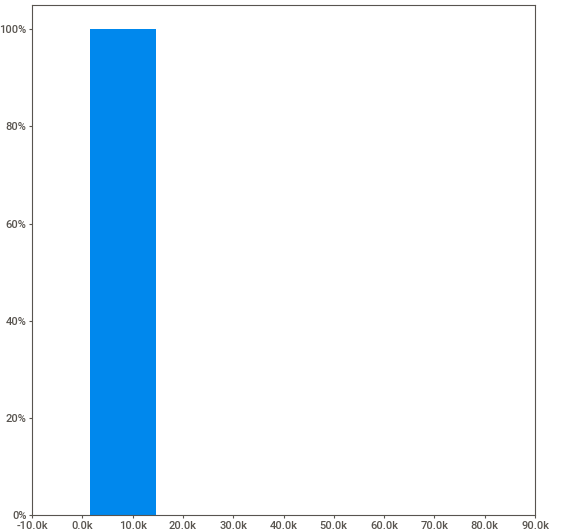
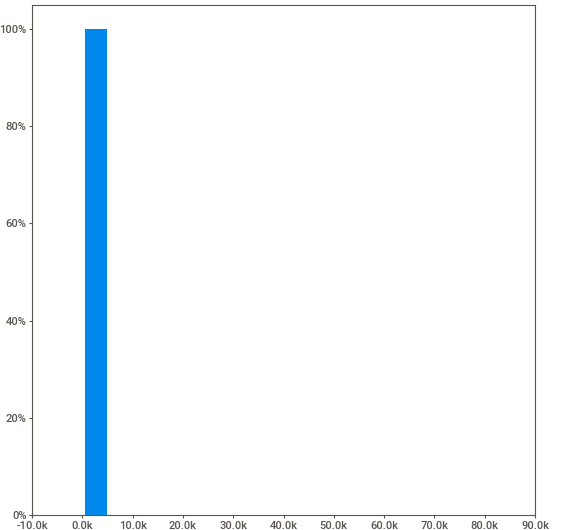
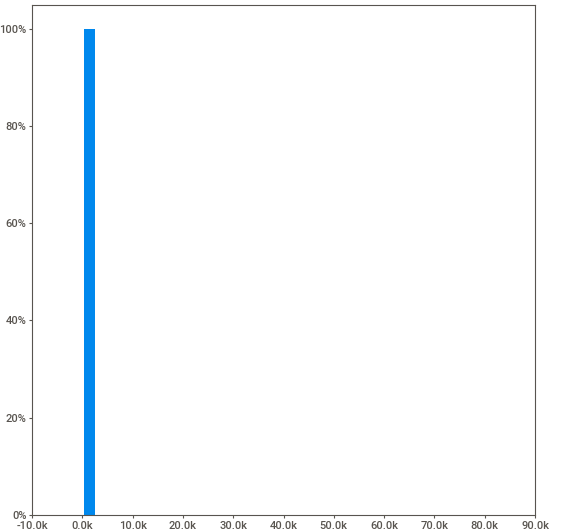
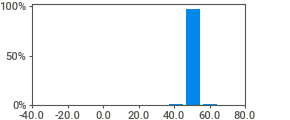
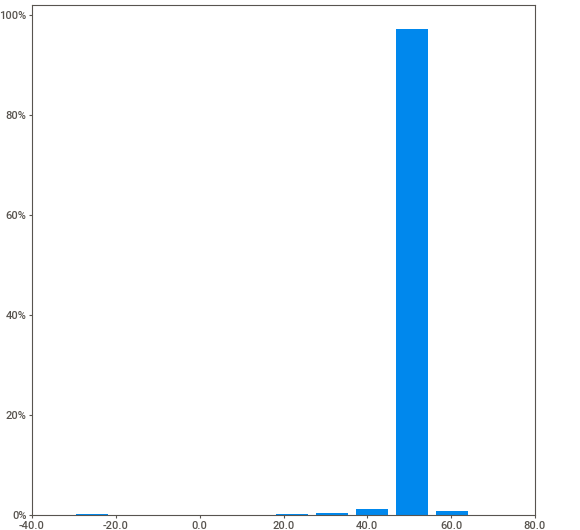
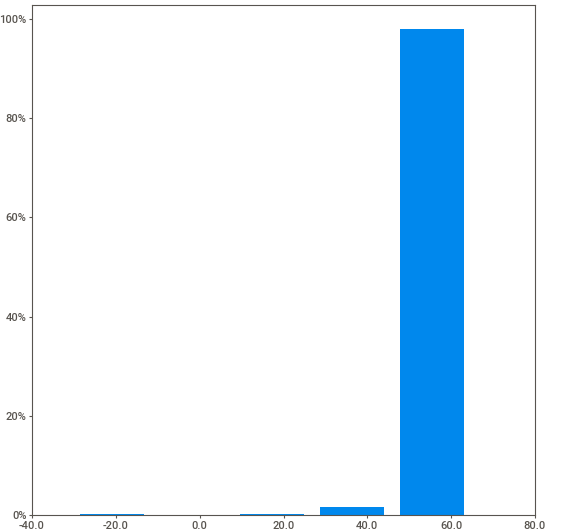
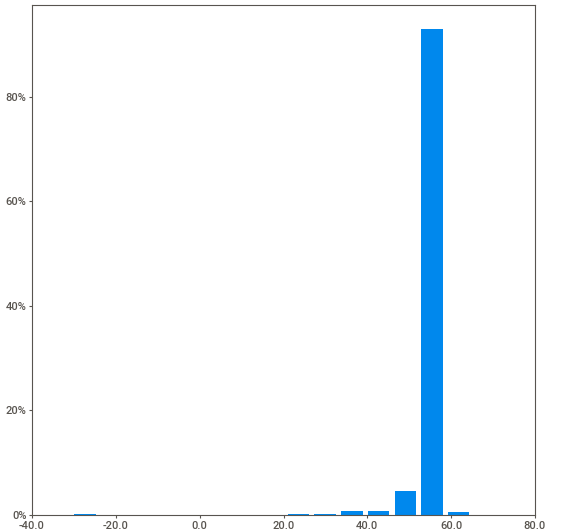
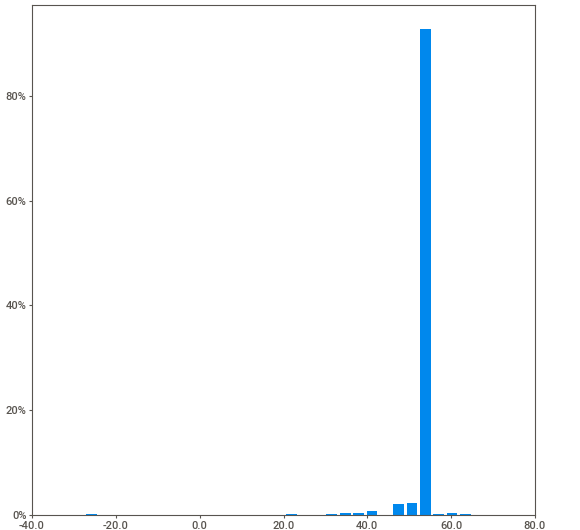
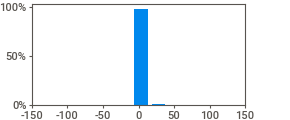
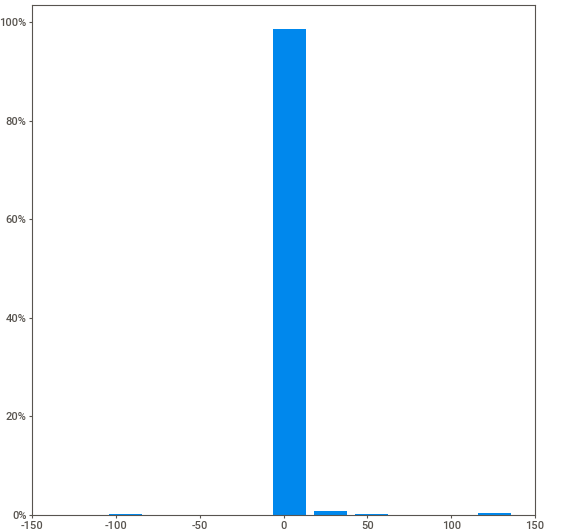
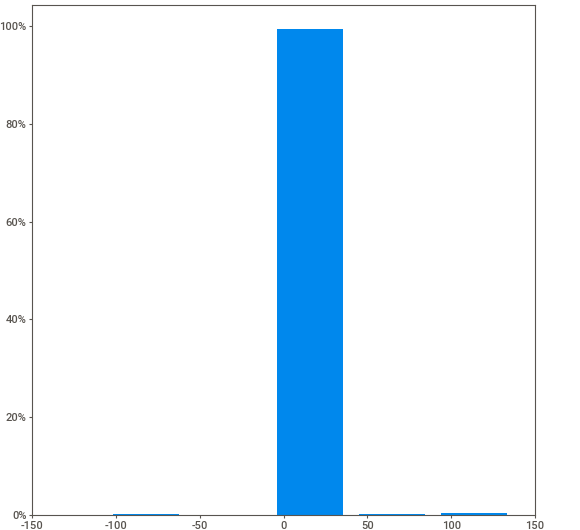
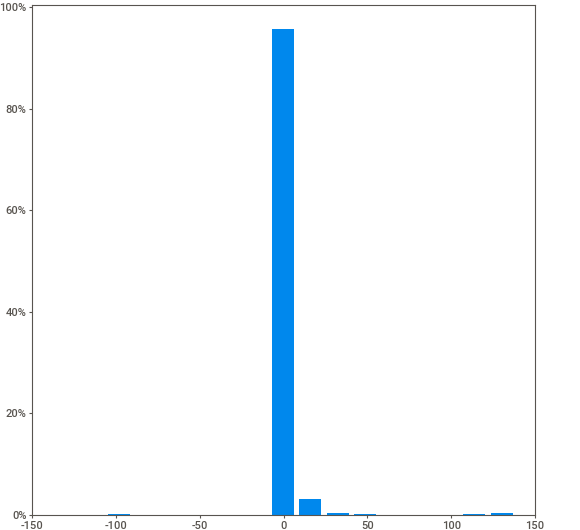
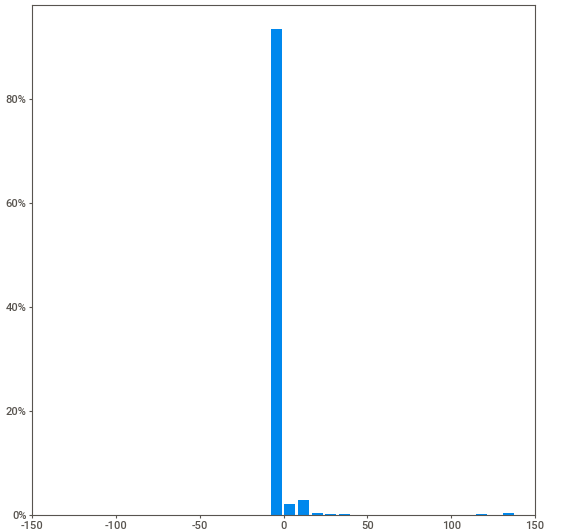
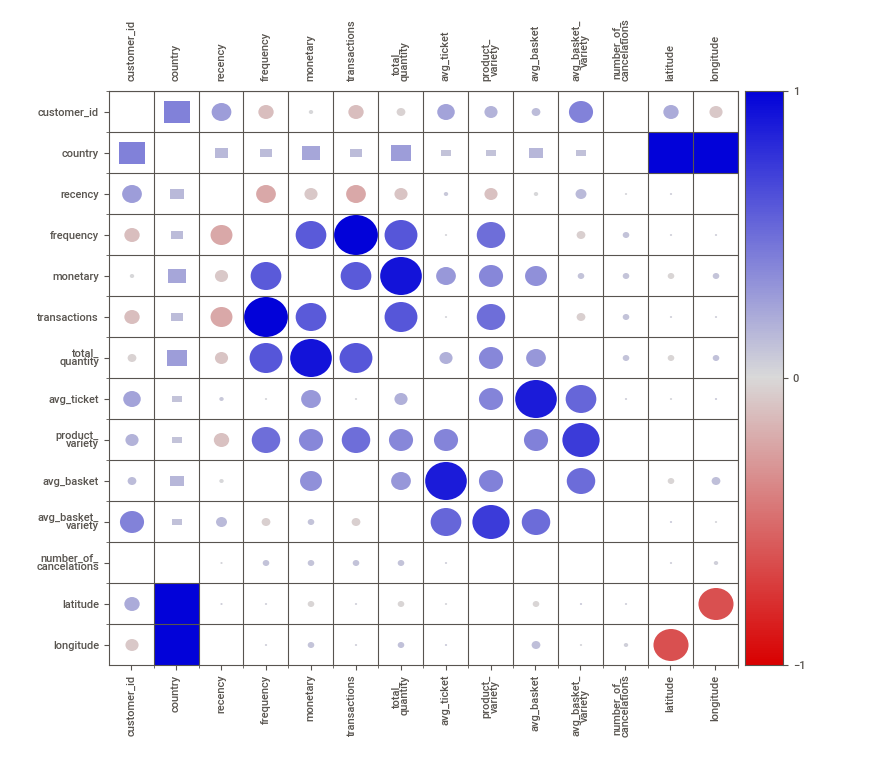
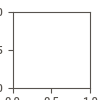

In [93]:
my_report = sweetviz.analyze(df_eda)
my_report.show_notebook(layout='widescreen')

### 4.1.1. Monetary

In [62]:
df_eda.sort_values('monetary', ascending=False).head()

customer_id         country  recency  frequency   monetary  \
992         14646     Netherlands      1.0   0.192513  278778.02   
481         18102  United Kingdom      0.0   0.160428  259657.30   
423         17450  United Kingdom      8.0   0.122995  189735.53   
65          14911         Ireland      1.0   0.532086  133007.13   
1121        12415       Australia     24.0   0.053476  123638.18   

      transactions   avg_ticket  product_variety   avg_basket  \
992           72.0  3818.876986            717.0  2692.547945   
481           60.0  4327.621667            162.0  1068.733333   
423           46.0  3872.153673            125.0  1409.000000   
65           199.0   547.354444           1815.0   316.588477   
1121          20.0  5151.590833            450.0  3206.083333   

      avg_basket_variety  number_of_cancelations   latitude   longitude  
992            28.246575                   288.0  52.132633    5.291266  
481             7.183333                     0.0  55.378051   -3.435973  
423             6.918367                   952.0  55.378051   -3.435973  
65             24.242798                  3332.0  53.412910   -8.243890  
1121           32.250000                   427.0 -25.274398  133.775136

In [63]:
df_feature_transaction.query('customer_id == 14646').groupby('customer_id').nunique()

invoice_no  stock_code  description  quantity  invoice_date  \
customer_id                                                                
14646                72         699          717        58            45   

             unit_price  country  
customer_id                       
14646                72        1

### 4.1.2. Product Variety

In [64]:
df_eda.sort_values('product_variety', ascending=False).head()

customer_id         country  recency  frequency   monetary  \
65          14911         Ireland      1.0   0.532086  133007.13   
46          12748  United Kingdom      0.0   0.550802   30486.53   
67          17841  United Kingdom      1.0   0.331551   40333.22   
4327        14096  United Kingdom      4.0   0.045455   53258.43   
5170        22221  United Kingdom     39.0   0.002674   14855.53   

      transactions    avg_ticket  product_variety   avg_basket  \
65           199.0    547.354444           1815.0   316.588477   
46           206.0    140.490922           1776.0   110.488479   
67           124.0    238.658107           1344.0   135.207101   
4327          17.0   3132.848824           1128.0   960.941176   
5170           1.0  14855.530000           1107.0  5197.000000   

      avg_basket_variety  number_of_cancelations   latitude  longitude  
65             24.242798                  3332.0  53.412910  -8.243890  
46             19.880184                  1535.0  55.378051  -3.435973  
67             44.982249                   203.0  55.378051  -3.435973  
4327          297.882353                     0.0  55.378051  -3.435973  
5170         1109.000000                     0.0  55.378051  -3.435973

### 4.1.3. Average Ticket

In [66]:
df_eda.query('avg_ticket > 50000')

customer_id         country  recency  frequency  monetary  transactions  \
5272        22312  United Kingdom     32.0   0.002674  52940.94           1.0   
5384        22383  United Kingdom     25.0   0.002674  50653.91           1.0   

      avg_ticket  product_variety  avg_basket  avg_basket_variety  \
5272    52940.94            101.0     14149.0               101.0   
5384    50653.91             99.0     13956.0                99.0   

      number_of_cancelations   latitude  longitude  
5272                     0.0  55.378051  -3.435973  
5384                     0.0  55.378051  -3.435973

In [95]:
df_eda.sort_values('avg_ticket').head(3)

customer_id         country  recency  frequency  monetary  transactions  \
969         19242  United Kingdom    357.0   0.002674      0.42           1.0   
1240        19391  United Kingdom    332.0   0.002674      0.65           1.0   
3963        21228  United Kingdom    147.0   0.002674      0.79           1.0   

      avg_ticket  product_variety  avg_basket  avg_basket_variety  \
969         0.42              1.0         1.0                 1.0   
1240        0.65              1.0         1.0                 1.0   
3963        0.79              1.0         1.0                 1.0   

      number_of_cancelations   latitude  longitude  
969                      0.0  55.378051  -3.435973  
1240                     0.0  55.378051  -3.435973  
3963                     0.0  55.378051  -3.435973

### 4.1.4. Average Basket

In [98]:
df_eda.sort_values('avg_basket').head(3)

customer_id         country  recency  frequency  monetary  transactions  \
3454        17900  United Kingdom    190.0   0.005348     15.00           2.0   
3277        16446  United Kingdom      0.0   0.005348      2.90           2.0   
2541        20001  United Kingdom    257.0   0.002674     16.95           1.0   

      avg_ticket  product_variety  avg_basket  avg_basket_variety  \
3454    3.750000              4.0    0.250000            2.750000   
3277    0.966667              3.0    0.666667            1.333333   
2541   16.950000              1.0    1.000000            1.000000   

      number_of_cancelations   latitude  longitude  
3454                    72.0  55.378051  -3.435973  
3277                 80995.0  55.378051  -3.435973  
2541                     0.0  55.378051  -3.435973

In [99]:
df_eda.sort_values('avg_basket', ascending=False).head(3)

customer_id         country  recency  frequency  monetary  transactions  \
5272        22312  United Kingdom     32.0   0.002674  52940.94           1.0   
5384        22383  United Kingdom     25.0   0.002674  50653.91           1.0   
4472        18251  United Kingdom     87.0   0.002674   4314.72           1.0   

      avg_ticket  product_variety  avg_basket  avg_basket_variety  \
5272    52940.94            101.0     14149.0               101.0   
5384    50653.91             99.0     13956.0                99.0   
4472     4314.72             16.0      7824.0                16.0   

      number_of_cancelations   latitude  longitude  
5272                     0.0  55.378051  -3.435973  
5384                     0.0  55.378051  -3.435973  
4472                     0.0  55.378051  -3.435973

In [101]:
df_filter.query('customer_id == 18251').head()

invoice_no stock_code                     description  quantity  \
339449     566595      21975  pack of 60 dinosaur cake cases       600   
339450     566595      21213     pack of 72 skull cake cases       600   
339451     566595      84992  72 sweetheart fairy cake cases       600   
339452     566595      84991     60 teatime fairy cake cases       600   
339453     566595      23340    vintage christmas cake frill       480   

       invoice_date  unit_price         country  customer_id  
339449   2017-09-11        0.42  United Kingdom        18251  
339450   2017-09-11        0.42  United Kingdom        18251  
339451   2017-09-11        0.42  United Kingdom        18251  
339452   2017-09-11        0.42  United Kingdom        18251  
339453   2017-09-11        1.45  United Kingdom        18251

### 4.1.5. Average Basket Variety

In [103]:
df_eda.sort_values('avg_basket_variety', ascending=False).head(3)

customer_id         country  recency  frequency  monetary  transactions  \
5170        22221  United Kingdom     39.0   0.002674  14855.53           1.0   
5667        22696  United Kingdom      1.0   0.002674   7150.07           1.0   
5677        22707  United Kingdom      0.0   0.002674   6756.06           1.0   

      avg_ticket  product_variety  avg_basket  avg_basket_variety  \
5170    14855.53           1107.0      5197.0              1109.0   
5667     7150.07            748.0      2150.0               748.0   
5677     6756.06            730.0      2010.0               730.0   

      number_of_cancelations   latitude  longitude  
5170                     0.0  55.378051  -3.435973  
5667                     0.0  55.378051  -3.435973  
5677                     0.0  55.378051  -3.435973

### 4.1.6. Number of Cancellations

In [106]:
df_eda.sort_values('number_of_cancelations', ascending=False).head(3)

customer_id         country  recency  frequency  monetary  transactions  \
3277        16446  United Kingdom      0.0   0.005348      2.90           2.0   
1231        15749  United Kingdom    235.0   0.008021  21535.90           3.0   
12          16029  United Kingdom     38.0   0.165775  58193.85          62.0   

       avg_ticket  product_variety   avg_basket  avg_basket_variety  \
3277     0.966667              3.0     0.666667            1.333333   
1231  5383.975000              5.0  2253.500000            3.750000   
12     881.725000             44.0   487.924242            3.909091   

      number_of_cancelations   latitude  longitude  
3277                 80995.0  55.378051  -3.435973  
1231                  9014.0  55.378051  -3.435973  
12                    8004.0  55.378051  -3.435973

In [107]:
df_filter.query('customer_id == 16446')

invoice_no stock_code                  description  quantity  \
194354     553573      22980       pantry scrubbing brush         1   
194355     553573      22982          pantry pastry brush         1   
540421     581483      23843  paper craft , little birdie     80995   
540422    C581484      23843  paper craft , little birdie    -80995   

       invoice_date  unit_price         country  customer_id  
194354   2017-05-16        1.65  United Kingdom        16446  
194355   2017-05-16        1.25  United Kingdom        16446  
540421   2017-12-07        2.08  United Kingdom        16446  
540422   2017-12-07        2.08  United Kingdom        16446

Should we remove transaction that perfectly match (same quantity and product) a cancellation? or remove this Outlier?

### 4.1.7 Quantity

In [98]:
df_eda.sort_values('total_quantity', ascending=False).head()

customer_id         country  recency  frequency   monetary  \
992         14646     Netherlands      1.0   0.192513  278778.02   
1121        12415       Australia     24.0   0.053476  123638.18   
65          14911         Ireland      1.0   0.532086  133007.13   
423         17450  United Kingdom      8.0   0.122995  189735.53   
481         18102  United Kingdom      0.0   0.160428  259657.30   

      transactions  total_quantity   avg_ticket  product_variety   avg_basket  \
992           72.0          196556  3818.876986            717.0  2692.547945   
1121          20.0           76946  5151.590833            450.0  3206.083333   
65           199.0           76931   547.354444           1815.0   316.588477   
423           46.0           69041  3872.153673            125.0  1409.000000   
481           60.0           64124  4327.621667            162.0  1068.733333   

      avg_basket_variety  number_of_cancelations   latitude   longitude  
992            28.246575                   288.0  52.132633    5.291266  
1121           32.250000                   427.0 -25.274398  133.775136  
65             24.242798                  3332.0  53.412910   -8.243890  
423             6.918367                   952.0  55.378051   -3.435973  
481             7.183333                     0.0  55.378051   -3.435973

Notes


**Recency:** Average Variability (good distribution for clustering)

**Frequency:** Low Variability (Highly concentrated distibution)

**Monetary:** High Variability (Highly concentrated in low values)

**Transactions:** Average Variability (Highly concentrated in low values)

**Average Ticket:** High Variability (Highly concentrated in low values)

**Product Variety:** High Variability (Highly concentrated but more sparse than the other features)

**Average Basket Size:** High Variability (Highly concentrated in low values)

**Average Basket Variety:** Average Variability (High concentration in low values, but more evenly distributed)

**Number of Cancellations:** High Variability (Highly concentrated in low values with a huge outlier)

In [147]:
# Removing bad users
df_eda = df_eda.query('~(customer_id == 16446)').copy()

customer_id         country  recency  frequency  monetary  transactions  \
0           17850  United Kingdom    372.0   0.090909   5288.63          34.0   
1           13047  United Kingdom     56.0   0.024064   3089.10           9.0   
2           12583          France      2.0   0.040107   6629.34          15.0   
3           13748  United Kingdom     95.0   0.013369    948.25           5.0   
4           15100  United Kingdom    333.0   0.008021    635.10           3.0   
...           ...             ...      ...        ...       ...           ...   
5676        22706  United Kingdom      1.0   0.002674   5699.00           1.0   
5677        22707  United Kingdom      0.0   0.002674   6756.06           1.0   
5678        22708  United Kingdom      0.0   0.002674   3217.20           1.0   
5679        22709  United Kingdom      0.0   0.002674   3950.72           1.0   
5680        12713         Germany      0.0   0.002674    794.55           1.0   

      total_quantity   avg_ticket  product_variety   avg_basket  \
0               1693   151.103714             21.0    48.371429   
1               1355   193.068750            105.0    84.687500   
2               4978   389.961176            116.0   292.823529   
3                439   189.650000             24.0    87.800000   
4                 58   105.850000              1.0     9.666667   
...              ...          ...              ...          ...   
5676            1747  5699.000000            634.0  1747.000000   
5677            2010  6756.060000            730.0  2010.000000   
5678             654  3217.200000             56.0   654.000000   
5679             731  3950.720000            217.0   731.000000   
5680             505   794.550000             37.0   505.000000   

      avg_basket_variety  number_of_cancelations   latitude  longitude  
0               8.742857                    40.0  55.378051  -3.435973  
1              12.125000                    35.0  55.378051  -3.435973  
2              13.823529                    50.0  46.227638   2.213749  
3               5.600000                     0.0  55.378051  -3.435973  
4               1.000000                    22.0  55.378051  -3.435973  
...                  ...                     ...        ...        ...  
5676          634.000000                     0.0  55.378051  -3.435973  
5677          730.000000                     0.0  55.378051  -3.435973  
5678           56.000000                     0.0  55.378051  -3.435973  
5679          217.000000                     0.0  55.378051  -3.435973  
5680           37.000000                     0.0  51.165691  10.451526  

[5680 rows x 14 columns]

## 4.3 Bivariate Analysis

In [162]:
#sns.pairplot(df_eda.drop(columns=['customer_id', 'country', 'frequency']))
#plt.figure(figsize=(12, 20))
fig = px.scatter_matrix(df_eda.drop(['country', 'customer_id', 'latitude', 'longitude'], axis=1), )
fig.update_layout(width=2000, height=1000, font={'size': 9})
fig.show()

**Notes**

Frequency has low variance
Avg ticket


## 4.4. Embedding 

In [105]:
df_embed = df_eda.drop(columns=['customer_id', 'country', 'latitude', 'longitude']).copy()

In [111]:
df_embed.head()

recency  frequency  monetary  transactions  total_quantity  avg_ticket  \
0    372.0   0.090909   5288.63          34.0            1693  151.103714   
1     56.0   0.024064   3089.10           9.0            1355  193.068750   
2      2.0   0.040107   6629.34          15.0            4978  389.961176   
3     95.0   0.013369    948.25           5.0             439  189.650000   
4    333.0   0.008021    635.10           3.0              58  105.850000   

   product_variety  avg_basket  avg_basket_variety  number_of_cancelations  
0             21.0   48.371429            8.742857                    40.0  
1            105.0   84.687500           12.125000                    35.0  
2            116.0  292.823529           13.823529                    50.0  
3             24.0   87.800000            5.600000                     0.0  
4              1.0    9.666667            1.000000                    22.0

## 4.4.1 PCA

In [112]:
scaler = pp.MinMaxScaler()
df_embed_sc = scaler.fit_transform(df_embed)

pca = PCA(n_components=df_embed_sc.shape[1])
pca.fit(df_embed_sc)
df_pca = pca.transform(df_embed_sc)
print(f'Original shape: {str(df_embed_sc.shape)}')
print(f'Reduced shape: {str(df_pca.shape)}')
print(f'{sum(pca.explained_variance_ratio_):.3f}')

Original shape: (5681, 10)
Reduced shape: (5681, 10)
1.000


<AxesSubplot:>

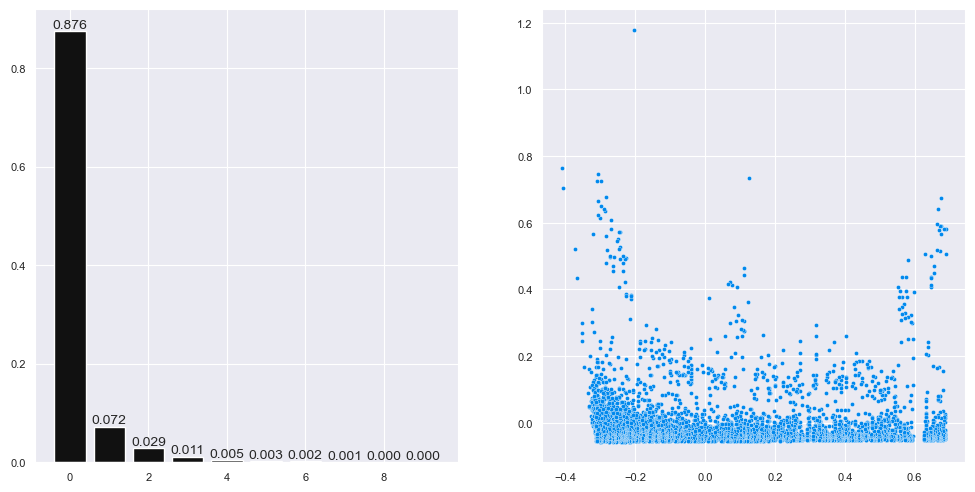

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x_pos = np.arange(pca.n_components_)
bar = ax[0].bar(x=x_pos, height=pca.explained_variance_ratio_, color='k')

ax[0].bar_label(bar, fmt='%.3f');

sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], ax=ax[1])

## 4.4.2 T-SNE

<AxesSubplot:>

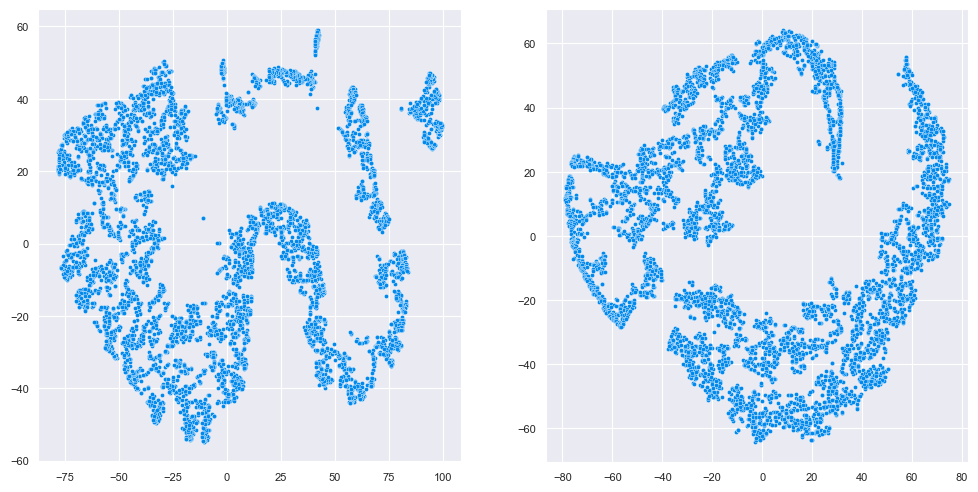

In [114]:
tsne = man.TSNE(perplexity=40, n_iter=1500, random_state=42, n_components=2)

df_tsne_sc = tsne.fit_transform(df_embed_sc)
df_tsne = tsne.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_tsne_sc[:, 0], y=df_tsne_sc[:, 1])

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1])

## 4.4.3 UMAP

<AxesSubplot:>

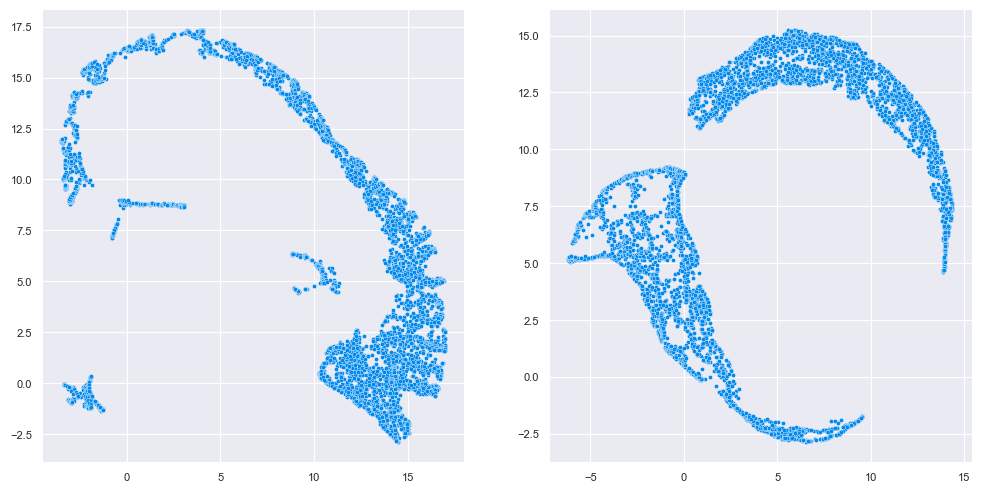

In [115]:
umap = um.UMAP(n_neighbors=40, random_state=42)

df_umap_sc = umap.fit_transform(df_embed_sc)
df_umap = umap.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_umap_sc[:, 0], y=df_umap_sc[:, 1])

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1])


## 4.4.4. Tree-Based Embedding

Vraiable that organize the customers in a way that I can group the most valuable clients.

In [116]:
X = df_embed.drop(columns='monetary')
y = df_embed['monetary']


# model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# training
rf.fit(X, y)

# Aplying the tree structure in the training set (Leafs)
df_leaf = pd.DataFrame(rf.apply(X)) 
#X.head()

Dados separados por folhas (pontos em cada estimadores).
Em qual folha o cliente caiu em cada árvore

In [117]:
df_leaf.shape

(5681, 100)

<AxesSubplot:>

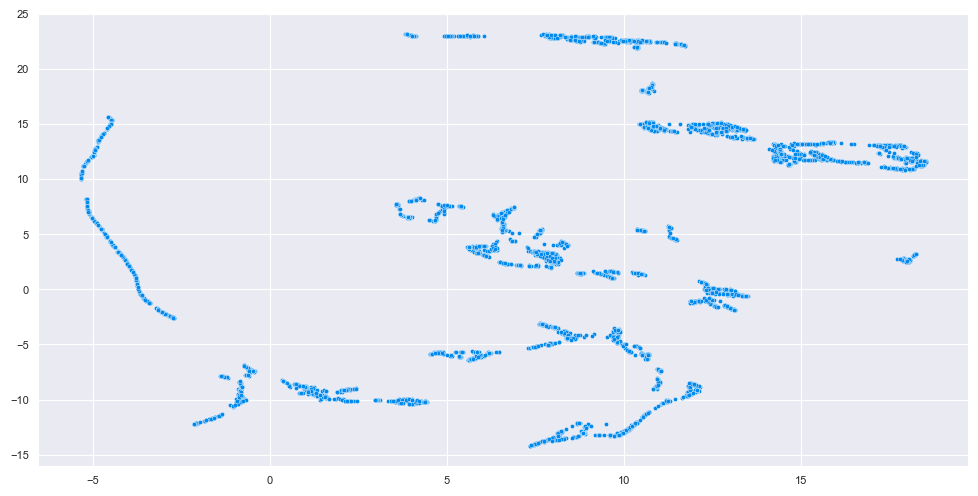

In [118]:
umap = um.UMAP(n_neighbors=40, random_state=42)

df_umap = umap.fit_transform(df_leaf)

plt.figure(figsize=(12, 6))

sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1])


Não preciso explicar porque dois elementos são vizinhos

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 5.0. Data Preparation

In [119]:
df_prep = df_eda.copy()

In [120]:
std = Pipeline([('standard', pp.StandardScaler())])
minmax = Pipeline([('minmax', pp.MinMaxScaler())])
robust = Pipeline([('robust', pp.RobustScaler())])
cols = ['recency', 'frequency', 'monetary', 'transactions', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancelations', 'latitude', 'longitude']
pass_cols = ['customer_id'] 
preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('minmax', minmax, cols)])


In [121]:
#df_prep_scaled = 
df_prep_scaled = pd.DataFrame(preprocess.fit_transform(df_prep))

In [122]:
cols = ['customer_id', 'recency', 'frequency', 'monetary', 'transactions', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancelations', 'latitude', 'longitude']
df_prep_scaled.columns = cols

In [123]:
df_prep_scaled

customer_id   recency  frequency  monetary  transactions  avg_ticket  \
0         17850.0  0.997319   0.160976  0.018969      0.160976    0.002846   
1         13047.0  0.150134   0.039024  0.011079      0.039024    0.003639   
2         12583.0  0.005362   0.068293  0.023779      0.068293    0.007358   
3         13748.0  0.254692   0.019512  0.003400      0.019512    0.003574   
4         15100.0  0.892761   0.009756  0.002277      0.009756    0.001991   
...           ...       ...        ...       ...           ...         ...   
5676      22706.0  0.002681   0.000000  0.020441      0.000000    0.107641   
5677      22707.0  0.000000   0.000000  0.024233      0.000000    0.127608   
5678      22708.0  0.000000   0.000000  0.011539      0.000000    0.060762   
5679      22709.0  0.000000   0.000000  0.014170      0.000000    0.074618   
5680      12713.0  0.000000   0.000000  0.002849      0.000000    0.015000   

      product_variety  avg_basket  number_of_cancelations  latitude  longitude  
0            0.011025    0.003401                0.000494  0.899657   0.420732  
1            0.057332    0.005968                0.000432  0.899657   0.420732  
2            0.063396    0.020678                0.000617  0.803864   0.443829  
3            0.012679    0.006188                0.000000  0.899657   0.420732  
4            0.000000    0.000666                0.000272  0.899657   0.420732  
...               ...         ...                     ...       ...        ...  
5676         0.348953    0.123456                0.000000  0.899657   0.420732  
5677         0.401874    0.142044                0.000000  0.899657   0.420732  
5678         0.030320    0.046205                0.000000  0.899657   0.420732  
5679         0.119074    0.051648                0.000000  0.899657   0.420732  
5680         0.019846    0.035675                0.000000  0.855559   0.477508  

[5681 rows x 11 columns]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 6.0. Feature Selection

In [124]:
df_fselect = df_prep.copy()[['customer_id',  'recency', 'frequency', 'monetary', 'transactions', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancelations', 'latitude', 'longitude']]
df_fselect_sc = df_prep_scaled.copy()[['customer_id',  'recency', 'frequency', 'monetary', 'transactions', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancelations', 'latitude', 'longitude']]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 7.0. Hyperparameter Fine-Tuning

In [125]:
df_k = df_fselect_sc.copy().reset_index(drop=True)

In [126]:
df_k.head()

customer_id   recency  frequency  monetary  transactions  avg_ticket  \
0      17850.0  0.997319   0.160976  0.018969      0.160976    0.002846   
1      13047.0  0.150134   0.039024  0.011079      0.039024    0.003639   
2      12583.0  0.005362   0.068293  0.023779      0.068293    0.007358   
3      13748.0  0.254692   0.019512  0.003400      0.019512    0.003574   
4      15100.0  0.892761   0.009756  0.002277      0.009756    0.001991   

   product_variety  avg_basket  number_of_cancelations  latitude  longitude  
0         0.011025    0.003401                0.000494  0.899657   0.420732  
1         0.057332    0.005968                0.000432  0.899657   0.420732  
2         0.063396    0.020678                0.000617  0.803864   0.443829  
3         0.012679    0.006188                0.000000  0.899657   0.420732  
4         0.000000    0.000666                0.000272  0.899657   0.420732

In [ ]:
## 7.1 

In [127]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Squares (WSS)

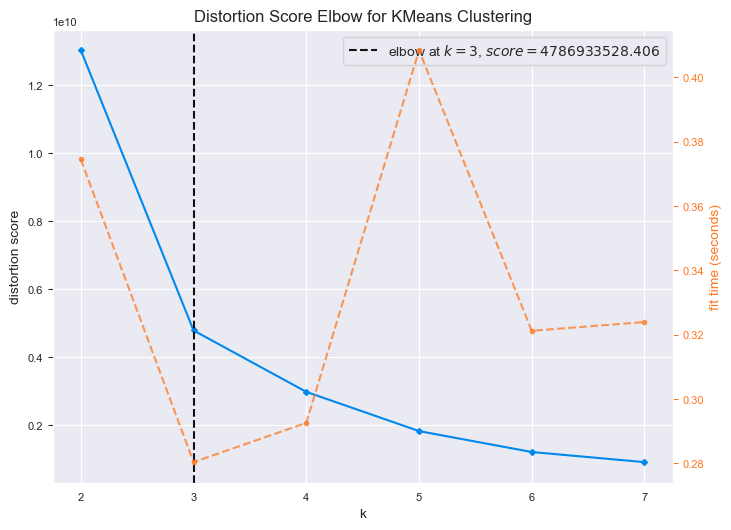

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [128]:
plt.figure(figsize=(8, 6))
kmeans = KMeans(init='random', n_init=10, max_iter=300, random_state=42)

vis = KElbowVisualizer(kmeans, k=clusters, timing=False)
vis.fit(df_k)
vis.show()

## 7.2 Sillhoutte Score

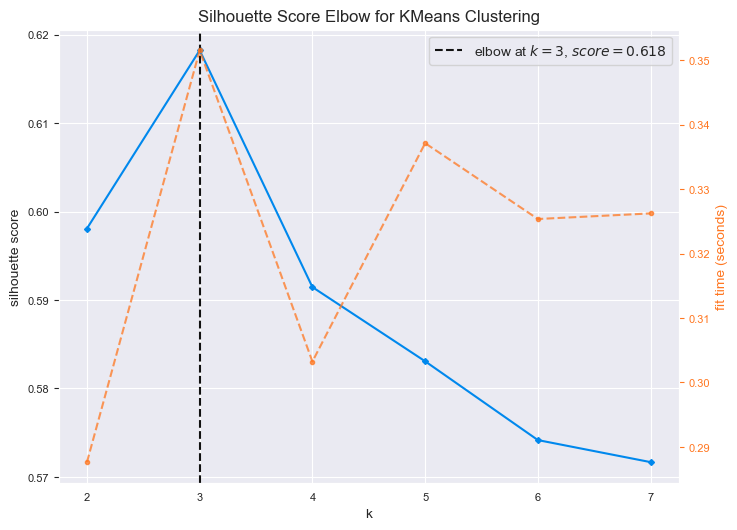

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [129]:
plt.figure(figsize=(8, 6))
kmeans = KMeans(init='random', n_init=10, max_iter=300, random_state=42)

vis = KElbowVisualizer(kmeans, k=clusters, metric='silhouette', timing=False)
vis.fit(df_k)
vis.show()

## 7.3 Sillhoutte Analysis

<Figure size 1000x600 with 0 Axes>

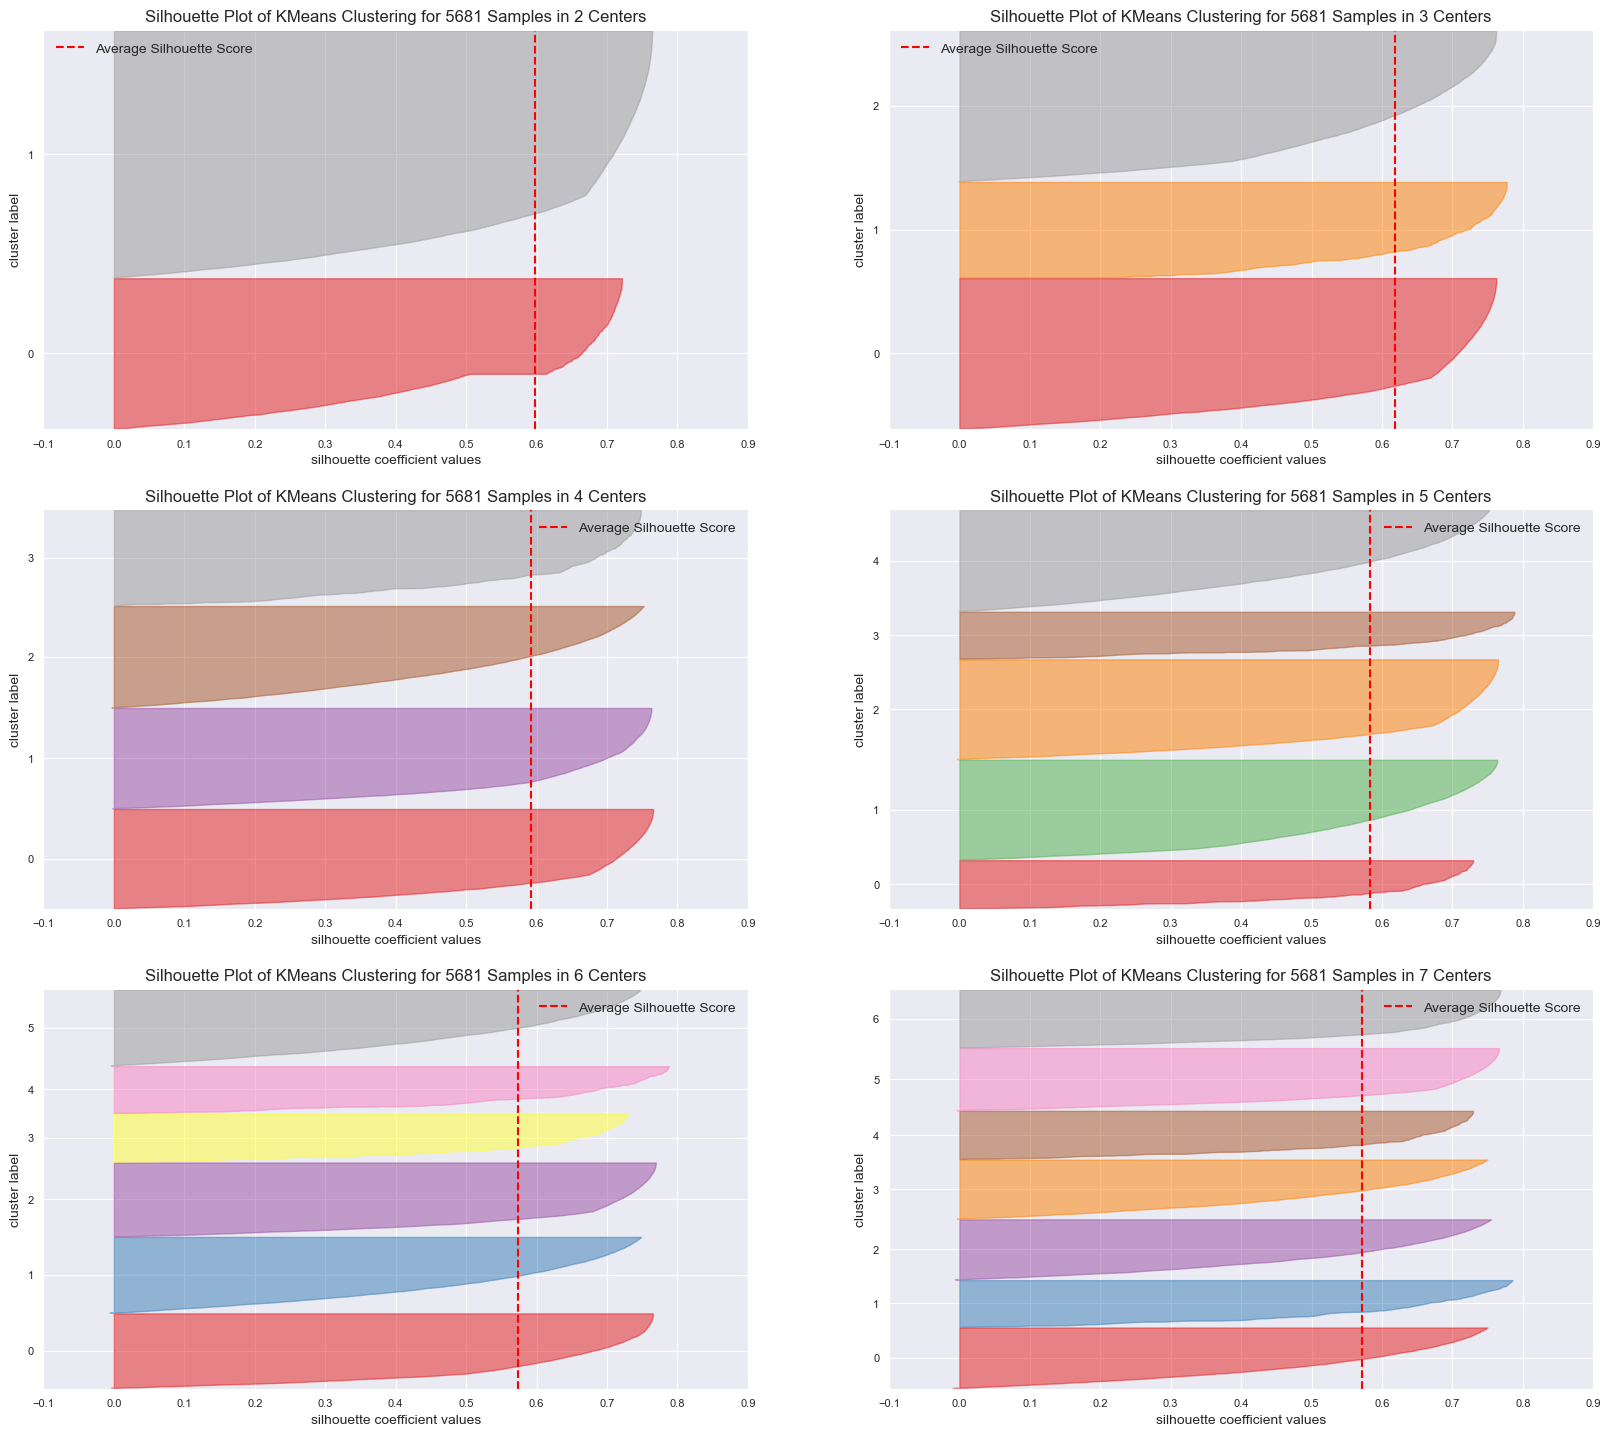

In [130]:
plt.figure(figsize=(10, 6))
n_clusters = [2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(3, 2, figsize=(20, 18))

for k in n_clusters:
    q, mod = divmod(k, 2)
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    vis = SilhouetteVisualizer(kmeans, color='yellowbricks', ax=ax[q-1][mod])
    vis.fit(df_k)
    vis.finalize()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Model Training

## 8.1. K-Means

In [141]:
# model
n_cluster=5
kmeans = KMeans(init='random', n_clusters=n_cluster, n_init=10, max_iter=300, random_state=42)

# model training
labels = kmeans.fit_predict(df_k)
ss = mt.silhouette_score(df_k, labels)
wss = kmeans.inertia_

print(f'Silhouette Score: {ss}')
print(f'Within CLuster Sum of Squares: {wss}')

Silhouette Score: 0.5830638764358975
Within CLuster Sum of Squares: 1827741389.325058


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 9.0. Cluster Analysis

## 9.1. Visualization

In [142]:
cluster_df = df_fselect.copy()
cluster_df_sc = df_fselect_sc.copy()
cluster_df['cluster'] = labels
cluster_df_sc['cluster'] = labels

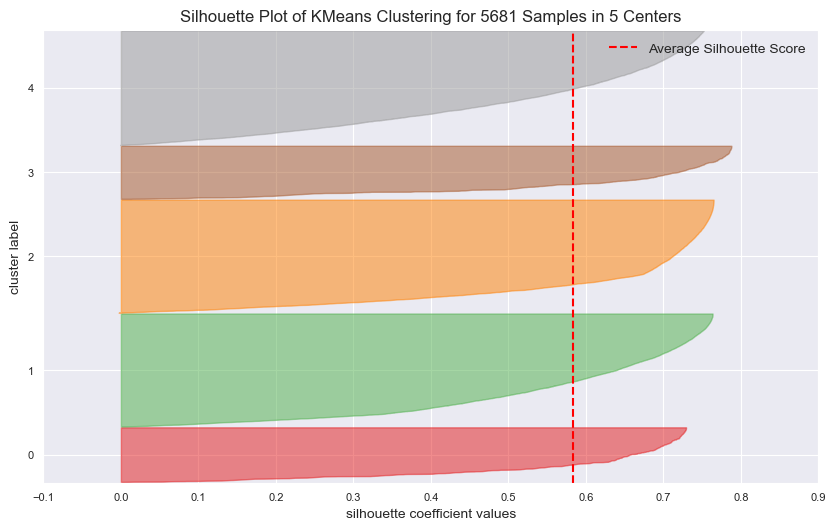

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5681 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [143]:
plt.figure(figsize=(10, 6))
vis = SilhouetteVisualizer(kmeans, color='yellowbricks')
vis.fit(df_k)
vis.show()

In [136]:
#sns.pairplot(cluster_df_sc.drop(columns='customer_id'), hue='cluster', palette='flare')

In [137]:
X = df_fselect_sc.copy().drop(columns='customer_id')

# TSNE
tsne = man.TSNE(random_state=42, perplexity=50)

features_tsne = tsne.fit_transform(X)

#tsne_scaled = man.TSNE(random_state=42)
#
#features_tsne_scaled = tsne.fit_transform(X_scaled)

In [138]:
# UMAP

u_map = um.UMAP(n_neighbors=50, random_state=42)

X_umap = u_map.fit_transform(X)

## TSNE

<AxesSubplot:>

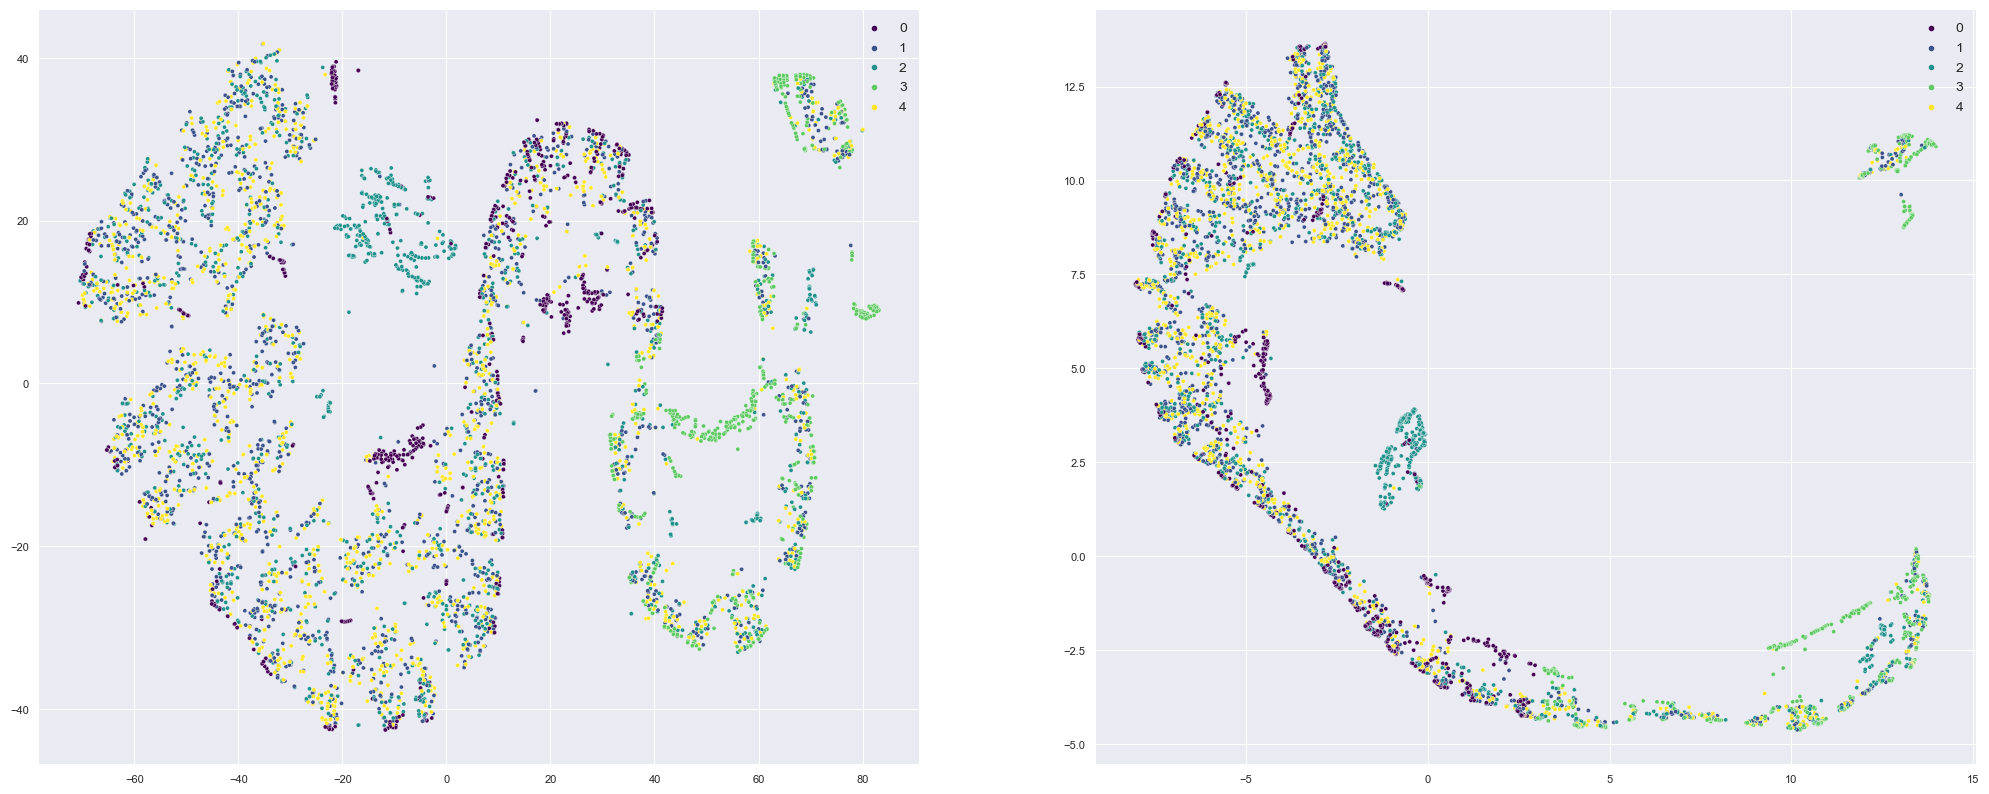

In [144]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

<AxesSubplot:>

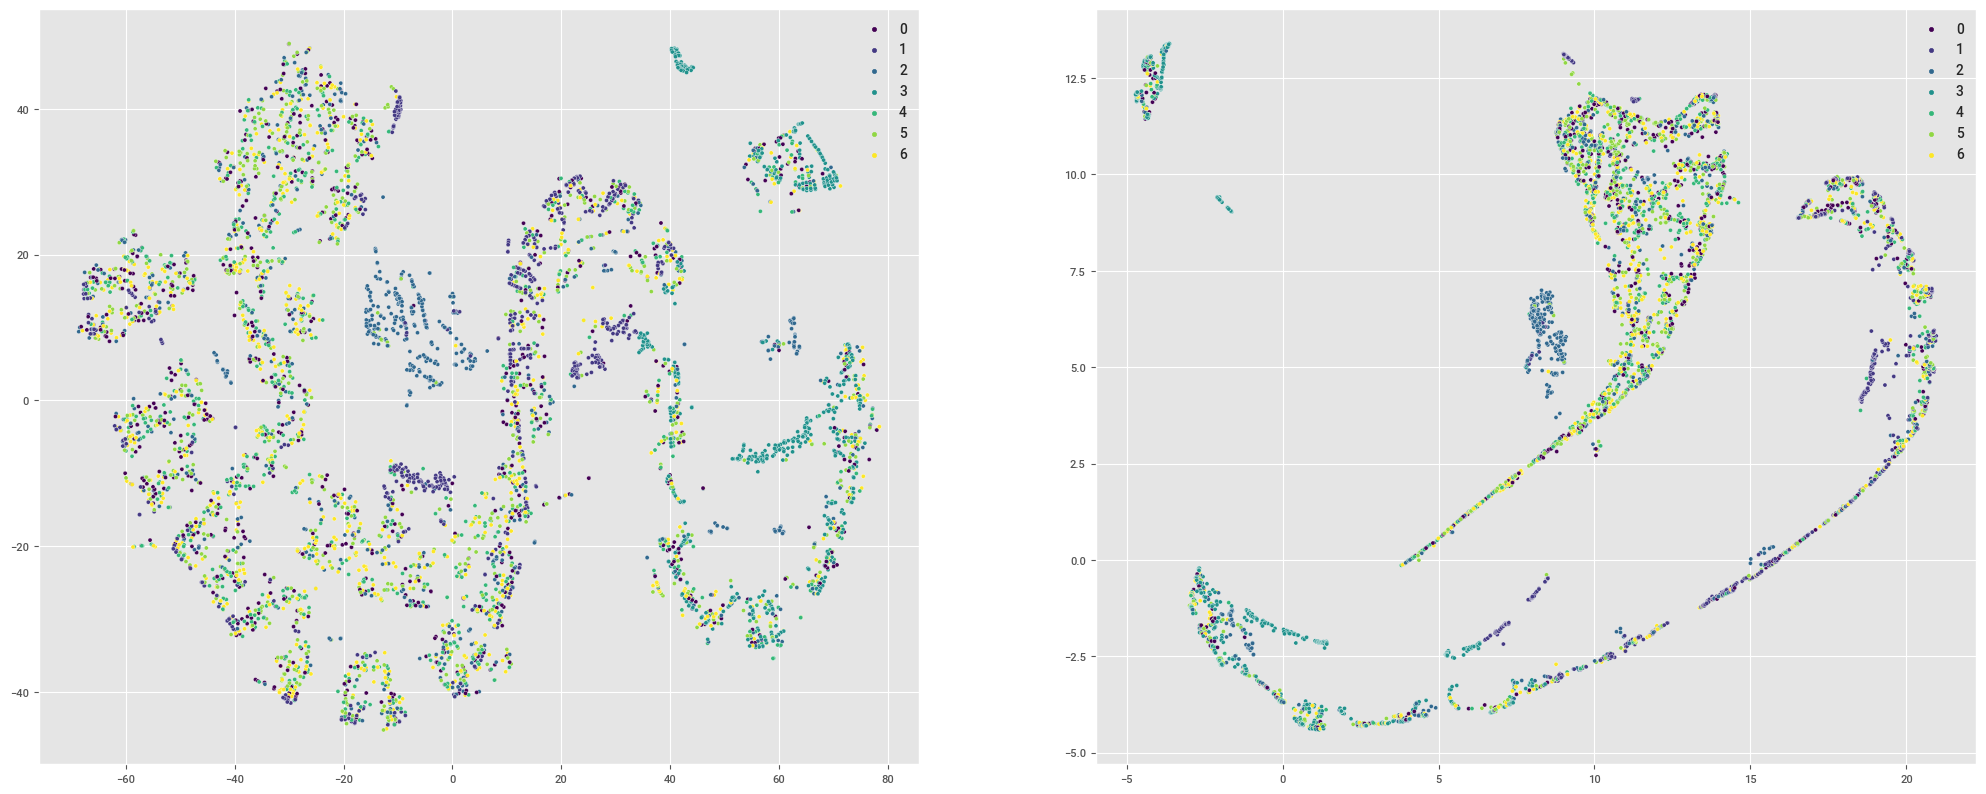

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

In [128]:
#df_fselect['cluster'] = labels_tsne

## 9.2. Clusters Profile

In [145]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['std_recency'] = cluster_df.groupby('cluster').std()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
prof['std_frequency'] = cluster_df.groupby('cluster').std()['frequency']
prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['std_monetary'] = cluster_df.groupby('cluster').std()['monetary']
#prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
#prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof['std_ticket'] = cluster_df.groupby('cluster').std()['avg_ticket']
prof['avg_product_variety'] = cluster_df.groupby('cluster').mean()['product_variety']
prof['std_product_variety'] = cluster_df.groupby('cluster').std()['product_variety']
prof

cluster  customer_id  percentual  avg_recency  std_recency  avg_frequency  \
0        0          693   12.198557   103.222222    62.300778       0.002674   
1        1         1432   25.206830    91.416899   100.628660       0.011295   
2        2         1433   25.224432    91.063503    99.344750       0.011710   
3        3          673   11.846506   290.054978    52.382280       0.002674   
4        4         1450   25.523675    93.400690   100.415006       0.011180   

   std_frequency  avg_monetary  std_monetary   avg_ticket   std_ticket  \
0       0.000000   1295.617922   3179.472770  1295.617922  3179.472770   
1       0.016884   1840.307109   9430.806530   287.509009   294.763186   
2       0.022464   2072.218339   6215.000263   370.976202   444.423348   
3       0.000000    908.137147   1778.077065   908.137147  1778.077065   
4       0.021653   1854.664848   8963.003301   320.639499   412.604088   

   avg_product_variety  std_product_variety  
0           107.906205           152.924010  
1            61.067737            77.450421  
2            60.933008            89.682523  
3            83.096582           120.363467  
4            63.793793            91.093212

In [186]:
cluster_df.query('cluster==1')

customer_id  recency  frequency  monetary  transactions  avg_ticket  \
68          19001    373.0        1.0   4951.37           1.0    9.413251   
71          19010    373.0        1.0      2.97           1.0    1.485000   
73          19011    373.0        1.0     99.75           1.0   99.750000   
79          19012    373.0        1.0      6.70           1.0    3.350000   
96          19014    373.0        1.0   6308.16           1.0   10.673706   
...           ...      ...        ...       ...           ...         ...   
5680        22705      1.0        1.0      3.35           1.0    1.675000   
5681        22706      1.0        1.0   5699.00           1.0    8.988959   
5682        22707      0.0        1.0   6756.06           1.0    9.254877   
5683        22708      0.0        1.0   3217.20           1.0   54.528814   
5684        22709      0.0        1.0   3950.72           1.0   18.206083   

      product_variety  avg_basket  number_of_cancelations   latitude  \
68                521    2.294677                     0.0  55.378051   
71                  2    1.000000                     0.0  55.378051   
73                  1    5.000000                     0.0  55.378051   
79                  2    1.000000                     0.0  55.378051   
96                588    2.499154                     0.0  55.378051   
...               ...         ...                     ...        ...   
5680                2    1.000000                     0.0  55.378051   
5681              634    2.755521                     0.0  55.378051   
5682              730    2.753425                     0.0  55.378051   
5683               56   11.084746                     0.0  55.378051   
5684              217    3.368664                     0.0  55.378051   

      longitude  cluster  
68    -3.435973        1  
71    -3.435973        1  
73    -3.435973        1  
79    -3.435973        1  
96    -3.435973        1  
...         ...      ...  
5680  -3.435973        1  
5681  -3.435973        1  
5682  -3.435973        1  
5683  -3.435973        1  
5684  -3.435973        1  

[1366 rows x 12 columns]

<AxesSubplot:xlabel='cluster', ylabel='avg_basket'>

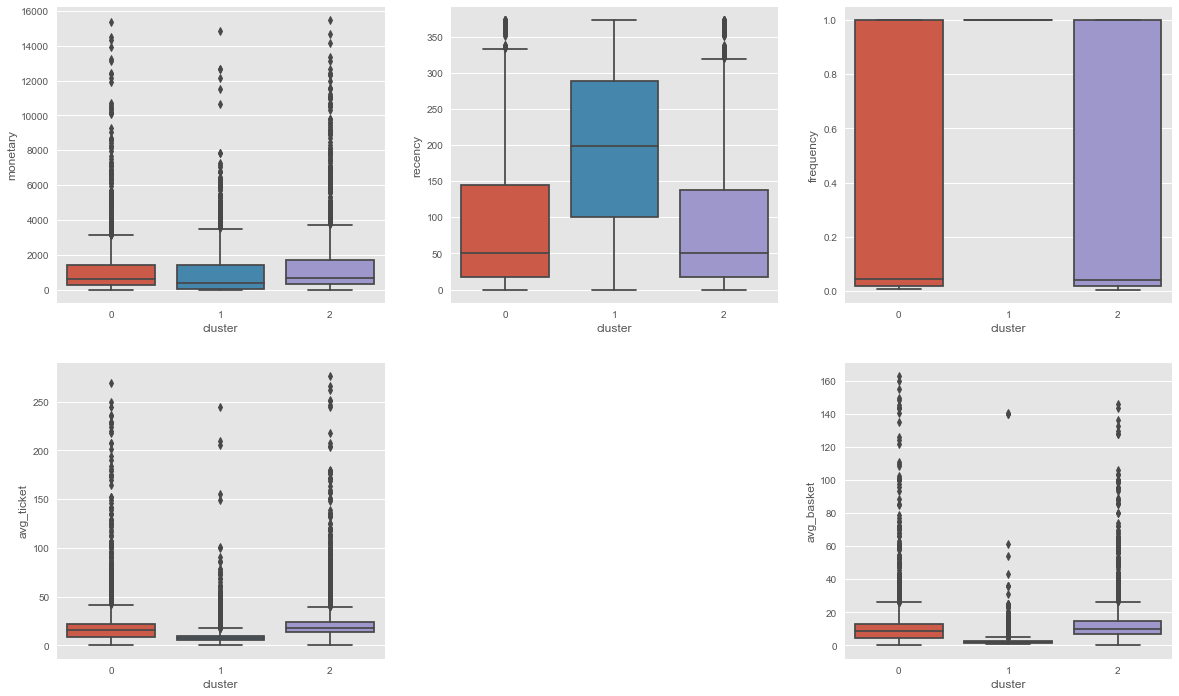

In [181]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
sns.boxplot(x='cluster', y='monetary', data=cluster_df.loc[cluster_df.monetary <= np.quantile(cluster_df.monetary, 0.99)])
plt.subplot(2, 3, 2)
sns.boxplot(x='cluster', y='recency', data=cluster_df)
plt.subplot(2, 3, 3)
sns.boxplot(x='cluster', y='frequency', data=cluster_df.loc[cluster_df.frequency <= np.quantile(cluster_df.frequency, 0.99)])
plt.subplot(2, 3, 4)
sns.boxplot(x='cluster', y='avg_ticket', data=cluster_df.loc[cluster_df.avg_ticket <= np.quantile(cluster_df.avg_ticket, 0.99)])
#plt.subplot(2, 3, 5)
#sns.boxplot(x='cluster', y='avg_unit_price', data=cluster_df.loc[cluster_df.avg_unit_price <= np.quantile(cluster_df.avg_unit_price, 0.99)])
plt.subplot(2, 3, 6)
sns.boxplot(x='cluster', y='avg_basket', data=cluster_df.loc[cluster_df.avg_basket <= np.quantile(cluster_df.avg_basket, 0.99)])

In [209]:
cluster_df.drop(columns=['customer_id', 'latitude', 'longitude']).describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997]).T

count         mean          std           min         1%  \
recency          4320.0    91.945602   100.090025  0.000000e+00   1.000000   
frequency        4320.0     4.257639     7.657526  1.000000e+00   1.000000   
monetary         4320.0  1919.924234  8321.216974  1.776357e-15  49.942500   
avg_ticket       4320.0    33.401639   181.637992  1.758769e-17   2.891739   
product_variety  4320.0    62.040278    86.493165  1.000000e+00   1.000000   
avg_quantity     4320.0    20.421175   101.043710  0.000000e+00   1.408235   
avg_unit_price   4320.0     3.466895     7.750726  1.225000e-01   0.692299   
cluster          4320.0     2.510417     1.003528  0.000000e+00   1.000000   

                         5%         10%         20%         50%          80%  \
recency            2.000000    5.000000   12.000000   50.000000   179.000000   
frequency          1.000000    1.000000    1.000000    2.000000     6.000000   
monetary         110.399000  152.994000  243.810000  653.365000  2005.174000   
avg_ticket         4.431502    5.868588    9.071015   16.878442    26.787368   
product_variety    4.000000    7.000000   13.000000   36.000000    93.000000   
avg_quantity       2.264986    3.061458    4.684681    9.631827    16.000000   
avg_unit_price     1.332370    1.651590    2.019266    2.841405     3.993969   
cluster            1.000000    1.000000    2.000000    2.000000     4.000000   

                         90%          95%          99%         99.7%  \
recency           262.100000   311.000000    368.00000    373.000000   
frequency           9.000000    13.000000     30.00000     55.000000   
monetary         3465.770000  5657.141000  17061.55330  53301.082130   
avg_ticket         46.712529    82.266763    325.57920    616.121950   
product_variety   143.100000   205.100000    354.81000    541.172000   
avg_quantity       25.727778    47.631985    200.00000    600.040133   
avg_unit_price      4.949500     6.063969     10.92625     23.567092   
cluster             4.000000     4.000000      4.00000      4.000000   

                        max  
recency             373.000  
frequency           206.000  
monetary         278778.020  
avg_ticket         9904.875  
product_variety    1822.000  
avg_quantity       4300.000  
avg_unit_price      327.225  
cluster               4.000

In [212]:
df_filter.invoice_date.max() - df_filter.invoice_date.min()

Timedelta('373 days 00:00:00')

In [313]:
cluster_df.query('cluster==2').sort_values('monetary', ascending=False)

customer_id  recency  frequency      monetary    avg_ticket  cluster
24923         14646      1.0       72.0  2.787780e+05  1.351979e+02        2
10893         18102      0.0       60.0  2.596573e+05  6.024531e+02        2
9825          17450      8.0       46.0  1.897355e+05  5.580457e+02        2
1399          14911      1.0      199.0  1.330071e+05  2.255888e+01        2
28710         12415     24.0       20.0  1.236382e+05  1.597393e+02        2
...             ...      ...        ...           ...           ...      ...
356845        15657     22.0        1.0  3.000000e+01  3.000000e+01        2
339175        16953     30.0        1.0  2.080000e+01  2.080000e+01        2
136358        16446      0.0        2.0  2.900000e+00  7.250000e-01        2
389544        12558      7.0        1.0  1.065814e-14  4.844610e-16        2
339375        18274     30.0        1.0  1.776357e-15  8.074349e-17        2

[2127 rows x 6 columns]

In [ ]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
#prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof

cluster  customer_id  percentual  avg_recency  avg_frequency  total_spent  \
0        0          618   14.242913   191.040453       1.873786   603.412930   
1        1          498   11.477299   308.369478       1.349398   392.575221   
2        2         2130   49.089652    18.699061       6.497653  3127.423573   
3        3         1093   25.190136    80.428179       2.622141   988.703744   

   number_of_cancelations  avg_ticket  
0                0.881877   34.513633  
1                0.532129   32.739829  
2                3.136620   29.271794  
3                1.213175   31.824948

In [ ]:
prof

cluster  customer_id  percentual  avg_recency  avg_frequency   avg_monetary
0        0          418    9.633556    26.248804      12.490431    6008.355598
1        1            3    0.069140     3.000000      60.000000  244804.703333
2        2           38    0.875778    13.868421      34.947368   24694.783684
3        3         3865   89.075824   100.321863       2.840103     926.552337
4        4           15    0.345702     7.733333      55.333333   76398.306000

In [130]:
prof

cluster  customer_id  percentual  avg_recency  avg_frequency  \
0        0         4071   93.115279    96.969295       3.641120   
1        1            6    0.137237     7.166667      89.000000   
2        2           28    0.640439     6.178571      57.821429   
3        3          267    6.107045    20.280899      19.528090   

    avg_monetary  avg_ticket  
0     946.696250   25.359654  
1  182181.981667  253.626345  
2   42614.387143  162.862605  
3    8089.028652   62.783157

## 9.3 Report

Cluster 1

    - Number of Customers: 6
    - Percentage of Customers: 0.14%
    - Average Recency: 7.2 
    - Average Frequency: 89
    - Average Monetary: 182,181.98

Cluster 2

    - Number of Customers: 31
    - Percentage of Customers: 0.71%
    - Average Recency: 14 
    - Average Frequency: 53.3
    - Average Monetary: 40,543.52

Cluster 0

    - Number of Customers: 4335
    - Percentage of Customers: 99.15%
    - Average Recency: 92.26 
    - Average Frequency: 4.6
    - Average Monetary: 1,372.58

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 10.0. Deploy to Production